Overview

1. Load and explore data
2. Visualize data to get more insights
3. Feature engineering
4. Build models: XGBoost, CatBoost, LightGBM
5. Hyperparameters fine-tuning
6. Evaluate models

# Setup library

In [1]:
!pip install pandas-profiling
!pip install catboost
!pip install --quiet optuna

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 0.0/83.5 kB ? eta -:--:--
     --------- ---------------------------- 20.5/83.5 kB 330.3 kB/s eta 0:00:01
     ------------------ ------------------- 41.0/83.5 kB 495.5 kB/s eta 0:00:01
     -------------------------------------- 83.5/83.5 kB 787.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
    --------------------------------------- 0.2/15.6 MB 7.6 MB/s eta 0:00:03
   - -------------------------------------- 0.6/15.6 MB 7.4 MB/s eta 0:00:03
   --- ------------------------------------ 1.3/15.6 MB 10.6 MB/s eta 0:00:02
   ------- -------------------------------- 3.0/15.6 MB 17.4 MB/s eta 0:00:01
   -------- ------------------------------- 3.4/15.6 MB 16.6 MB/s eta 0:00:01
   -------------- ------------------------- 5.5/15.6 MB 23.5 MB/s eta 0:00:01
   -------------------------- ------------- 10.1/15.6 MB 34.2 MB/s eta 0:00:01


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anylabeling 0.3.3 requires onnxruntime==1.14.1, which is not installed.
anylabeling 0.3.3 requires onnx==1.13.1, but you have onnx 1.14.0 which is incompatible.
fastapi 0.96.0 requires pydantic!=1.7,!=1.7.1,!=1.7.2,!=1.7.3,!=1.8,!=1.8.1,<2.0.0,>=1.6.2, but you have pydantic 2.6.1 which is incompatible.
fastparquet 2023.10.1 requires pandas>=1.5.0, but you have pandas 1.4.4 which is incompatible.
sqlmodel 0.0.8 requires pydantic<2.0.0,>=1.8.2, but you have pydantic 2.6.1 which is incompatible.
sqlmodel 0.0.8 requires SQLAlchemy<=1.4.41,>=1.4.17, but you have sqlalchemy 2.0.25 which is incompatible.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, fbeta_score, make_scorer, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler, SMOTE

# import pandas_profiling

import optuna
import xgboost
import catboost as cb
import lightgbm as lgb
from lightgbm import LGBMClassifier

d:\Anaconda3\envs\venv_dev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Anaconda3\envs\venv_dev\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
d:\Anaconda3\envs\venv_dev\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprec

# Explore and preprocessing data

## Load data

In [3]:
df = pd.read_csv(r"E:\BaoLong\mlops_diabetes_prediction\data\diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Fields explanation:

1. Pregnancies: Number of times pregnant
2. Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. BloodPressure: Diastolic blood pressure (mm Hg)
4. SkinThickness: Triceps skin fold thickness (mm)
5. Insulin: 2-Hour serum insulin (mu U/ml)
6. BMI: Body mass index
7. DiabetesPedigreeFunction: Diabetes pedigree function
8. Age: Age (years)
9. Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0

In [4]:
num_cols = df.select_dtypes(["int", "float"]).columns
cat_cols = df.select_dtypes("object").columns

print(f"There are {len(num_cols)} numerical columns")
print(f"There are {len(cat_cols)} categorical columns")

There are 9 numerical columns
There are 0 categorical columns


In [5]:
# Remove column have full of zeros
column_full_0 = []
for column_name in num_cols:
    if (df[column_name] == 0).all():
        column_full_0.append(column_name)

In [7]:
column_full_0

[]

In [8]:
# Inspect columns missing values
def calculate_missing_data(data):
    ## Calculate missing data in the dataset
    total_data = len(data)
    total_miss = data.isnull().sum()
    percent_missing = total_miss * 100 / total_data
    missing_data = pd.concat(
        (total_miss, percent_missing),
        axis = 1,
        keys = ["Missing value", "Percentage missing value"]
    ).sort_values("Percentage missing value", ascending=False)
    missing_data = missing_data[missing_data["Percentage missing value"] != 0]

    return missing_data

missing_data = calculate_missing_data(df)
if not len(missing_data):
    print("Dataset is ready to use")
else:
    print("Dataset needed to handle missing value")
     

Dataset is ready to use


<Axes: >

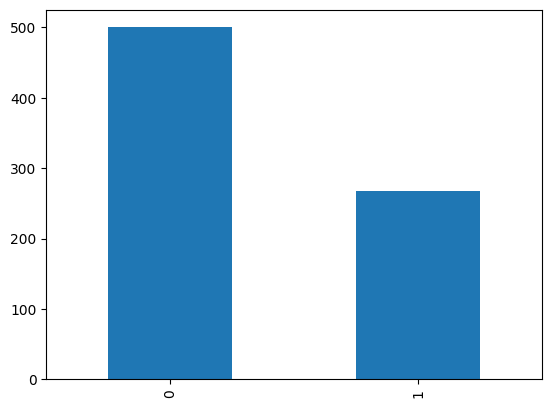

In [10]:
# Inspect target column
df["Outcome"].value_counts().plot.bar()

# Feature engineering

Investigate the relationship between each numerical feature and target feature

In [11]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [13]:
#sns.countplot(x="Pregnancies", hue="Outcome", data=df)
df[["Pregnancies", "Outcome"]].groupby("Pregnancies", as_index=False).mean().sort_values(by="Outcome", ascending=False)

,Pregnancies,Outcome
16,17,1.000000
15,15,1.000000
14,14,1.000000
9,9,0.642857
11,11,0.636364
8,8,0.578947
7,7,0.555556
13,13,0.500000
12,12,0.444444
10,10,0.416667


In [15]:
for column in df.columns:
    if column not in ["Pregnancies", "Outcome"]:
        print(column)
        print()
        print(df[["Outcome", column]].groupby("Outcome", as_index=False).mean().sort_values(by="Outcome", ascending=False))
        print("*" * 30)

Glucose

   Outcome     Glucose
1        1  141.257463
0        0  109.980000
******************************
BloodPressure

   Outcome  BloodPressure
1        1      70.824627
0        0      68.184000
******************************
SkinThickness

   Outcome  SkinThickness
1        1      22.164179
0        0      19.664000
******************************
Insulin

   Outcome     Insulin
1        1  100.335821
0        0   68.792000
******************************
BMI

   Outcome        BMI
1        1  35.142537
0        0  30.304200
******************************
DiabetesPedigreeFunction

   Outcome  DiabetesPedigreeFunction
1        1                  0.550500
0        0                  0.429734
******************************
Age

   Outcome        Age
1        1  37.067164
0        0  31.190000
******************************


**Overall, diabete people have higher mean diagnostic measures than non-diabete people.**

In [16]:
data_train, data_test = train_test_split(df, test_size = 0.1, random_state = 42)
y_train = data_train.pop('Outcome')
y_test = data_test.pop('Outcome')


print(f"Data train: X_train shape {data_train.shape}, y_train shape {y_train.shape}")
print(f"Data test: X_test shape {data_test.shape}, y_test shape {y_test.shape}")

Data train: X_train shape (691, 8), y_train shape (691,)
Data test: X_test shape (77, 8), y_test shape (77,)


In [18]:
# Model results storage
scores_with_different_models = {
    "accuracy_scores": [],
    "precision_scores": [],
    "recall_scores": [],
    "fbeta_scores": []
}

# Model hyperparameters storage
hyperparameters_storage = {
    "LightGBM": None,
    "CatBoost": None,
    "XGBoost": None
}

In [19]:
# Prepare model evaluation metrics
def fbeta(y_true, y_predict):
    ## Function used to calculate f_beta score
    return fbeta_score(y_true, y_predict, beta=np.sqrt(5))

def metrics(y_true, y_predict):
    ## Metrics used to evaluate models
    accuracy = accuracy_score(y_true, y_predict)
    precision = precision_score(y_true, y_predict)
    recall = recall_score(y_true, y_predict)
    f_score = fbeta(y_true, y_predict)

    return accuracy, precision, recall, f_score 


def display_metrics(accuracy, precision, recall, fbeta_score):
    ## Show metric results to screen
    print(f"Accuracy: {accuracy:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    print(f"Fbeta_score: {fbeta_score:.5f}")

In [20]:
# Train model with Kfold technique

def kfold_training(model, X, y):
    ## Train model on different training sets and evaluate on different valuation sets
    skfolds = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    scores = {"accuracy_scores": [],
              "precision_scores": [],
              "recall_scores": [],
              "fbeta_scores": []}
    count = 0
    for train_index, val_index in skfolds.split(X, y):
        X_train_folds = X.iloc[train_index, :]
        X_val_fold = X.iloc[val_index, :]
        y_train_folds = y[train_index]
        y_val_fold = y[val_index]
        model.fit(X_train_folds, y_train_folds)
        y_predict = model.predict(X_val_fold)
        accuracy, precision, recall, f_score = metrics(y_val_fold, y_predict)
        scores["accuracy_scores"].append(accuracy)
        scores["precision_scores"].append(precision)
        scores["recall_scores"].append(recall)
        scores["fbeta_scores"].append(f_score)
        count += 1

    mean_accuracy = np.array(scores["accuracy_scores"]).mean()
    mean_precision = np.array(scores["precision_scores"]).mean()
    mean_recall = np.array(scores["recall_scores"]).mean()
    mean_fscore = np.array(scores["fbeta_scores"]).mean()

    return mean_accuracy, mean_precision, mean_recall, mean_fscore

# LightGBM

In [21]:
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [22]:
lgbmc = LGBMClassifier(num_leaves=100)
mean_accuracy, mean_precision, mean_recall, mean_fscore = kfold_training(lgbmc, data_train, y_train)
display_metrics(mean_accuracy, mean_precision, mean_recall, mean_fscore)

[LightGBM] [Info] Number of positive: 200, number of negative: 375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 575, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347826 -> initscore=-0.628609
[LightGBM] [Info] Start training from score -0.628609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [23]:
# Hyperparameters fine-tuning
def objective(trial, X_train, y_train):
    max_depth = trial.suggest_int("max_dept", 2, 14)
    param_grid = {
        "objective": "binary",
        "metric": ["binary_logloss", "auc"],
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 4, 2**max_depth),
        "max_depth": max_depth,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 200),
        "max_bin": trial.suggest_int("max_bin", 10, 255),
        "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
        "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1)
    }

    score = model_lgbm_cv(params=param_grid,
                        X_train=X_train,
                        y_train=y_train)

    return score

def model_lgbm_cv(params, X_train, y_train):
    train_data = lgb.Dataset(X_train, y_train)
    result = lgb.cv(params=params,
                    train_set=train_data,
                    num_boost_round=300,
                    nfold=5)
    print(result)
    return result["valid binary_logloss-mean"][-1]

In [24]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, data_train, y_train), n_trials=50)

[I 2024-02-15 14:15:41,773] A new study created in memory with name: no-name-2031d863-ffcc-42a8-b790-4d1d51df3d12
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inste

{'valid binary_logloss-mean': [0.6312214401687509, 0.5805587286728447, 0.5735164632701242, 0.5559658949713235, 0.528410820741094, 0.5142556442208552, 0.5112872020249586, 0.5034341254208972, 0.5001083395315491, 0.49645860938843417, 0.4948067460127318, 0.49498645731976626, 0.4931622412324249, 0.49134189400832246, 0.4875082735842013, 0.4869505055412836, 0.48712076607892146, 0.48621531826995723, 0.48454230096760253, 0.4850074503629318, 0.4861151311180773, 0.4851863876253639, 0.4857365965107844, 0.4851845526801545, 0.4864916083018153, 0.48818228925668317, 0.4879433616713572, 0.4890001938540577, 0.4891810211178851, 0.48991673604530117, 0.48950525140683754, 0.48967592124673204, 0.4925398757511864, 0.49299664659643766, 0.49303450196935844, 0.49303630507550017, 0.4937364064269188, 0.49456903962577786, 0.4950488726407068, 0.4946744028365326, 0.49546179366004806, 0.4964021095047621, 0.4972589380410131, 0.4977496054938254, 0.49793111394055145, 0.4982536283666866, 0.4983064366402915, 0.499017870684

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6395379377048848, 0.6354943325283882, 0.6316277676772095, 0.6252026616346367, 0.6195398210413656, 0.6160569961077027, 0.6107641073343224, 0.6061405751021568, 0.602280725201228, 0.5982373791031008, 0.5936097658995587, 0.5902834073361193, 0.5868568032759625, 0.5833090658890014, 0.5800536789867805, 0.5768817407742577, 0.5741008120558015, 0.5709587675152542, 0.5680838851792978, 0.5652292935555558, 0.5624669863426929, 0.5599275399913044, 0.5577632724432552, 0.5551783471357382, 0.5528870792661891, 0.5502997290160223, 0.5483327597396289, 0.5464935858913251, 0.5443619940985693, 0.5423614787922086, 0.5409140201453353, 0.5391909080320428, 0.537648637728893, 0.5363557317652992, 0.5348315491271178, 0.533404011036855, 0.5324495126418207, 0.5309138087744121, 0.5297278499194797, 0.5285351911520417, 0.5270154187354913, 0.5258167807913632, 0.5243490289293753, 0.5229283999314926, 0.5217810139949985, 0.5208982600328831, 0.519704852975648, 0.5190115227986833, 0.51832045761

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6110106199041766, 0.590597487378906, 0.5742765805912234, 0.5523910097960718, 0.5427348182841191, 0.5336605735598957, 0.5257086606380156, 0.5215259305868284, 0.5172827034758113, 0.5102102100559824, 0.5050011662194132, 0.5025837320704014, 0.5009287331378833, 0.49977978253271693, 0.49774803671206813, 0.49637468379584637, 0.4954254909912878, 0.4937040001118536, 0.49319962706700754, 0.4919831397555773, 0.4910023382918244, 0.4917715103212079, 0.4909369937540854, 0.4909690342970916, 0.4907186230517677, 0.49042065083618525, 0.49127540320463536, 0.49131189644777085, 0.49128594704340556, 0.49068683685797987, 0.4906308418071653, 0.49017621419496454, 0.4900056453708256, 0.4900915378484477, 0.49086423560000075, 0.48972546530754624, 0.49074772768138175, 0.49095002446140185, 0.49095815140401877, 0.4914941086745933, 0.49141002801328054, 0.49106305515606097, 0.49059888736765067, 0.49134301870772135, 0.49016895916960407, 0.49099723584081534, 0.4915542772344663, 0.4910297

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6166022445113386, 0.587516717164, 0.581461965799069, 0.5726235103639872, 0.5648034955957655, 0.5290261119071438, 0.5112105442250494, 0.5059890170600745, 0.5058188928901176, 0.49569972340754465, 0.48948400502800976, 0.48513040271622987, 0.48571115647655566, 0.4840570446171088, 0.4832034460428688, 0.4823924788855953, 0.48339333055887446, 0.48230513923230856, 0.48452629936256597, 0.482907146920596, 0.4822472029549406, 0.48241733024774136, 0.4818970083089204, 0.4825808570968255, 0.48292144439330975, 0.4828197908866495, 0.48437352271948136, 0.48485044514428133, 0.4859398117114198, 0.48673925660916195, 0.48701688757453343, 0.4887336546778166, 0.48941205143820576, 0.4890633734730204, 0.49071880616886165, 0.49117352211698123, 0.49207869756591605, 0.4926004362861057, 0.49286838462008814, 0.49335765384763175, 0.4945945088616027, 0.4953703104736894, 0.4966093710374979, 0.49660706830781043, 0.4966590863211408, 0.4969217841221333, 0.49824736946502945, 0.499317696926

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6267594942614296, 0.6150789998545079, 0.6050244521545655, 0.5904773550425165, 0.578979927448181, 0.5744158673833372, 0.5651894674514362, 0.5568483889010496, 0.5513867740445881, 0.5449222055067748, 0.5386502238682119, 0.5353077856758951, 0.530631849344997, 0.5267495786452688, 0.5225439611853878, 0.5199789061332332, 0.5166492487935619, 0.5139501808752572, 0.5125804011286612, 0.5102394517355504, 0.5080095929703062, 0.5065943436174348, 0.5050819611811179, 0.5034507031791832, 0.5015881643901257, 0.500324017291172, 0.4992670045809521, 0.4978194318376759, 0.49668841609020004, 0.49566469683583136, 0.494936322849163, 0.4939058385644611, 0.49330141749077977, 0.492361685396223, 0.49146518459143806, 0.4907220620738255, 0.48991038230211253, 0.4890055275511781, 0.4883291539332319, 0.4879772779838555, 0.48739867433033546, 0.48683709334553854, 0.4864929396494781, 0.48650772640145723, 0.4860074710633713, 0.4856112698177177, 0.4854105711432399, 0.4851137736359141, 0.4847

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6175914980169864, 0.5886747406001756, 0.5846170338879693, 0.5758462972464954, 0.5666779468695856, 0.5339181302039846, 0.5162084492856319, 0.5114261649663445, 0.5110624388319438, 0.5000936355150427, 0.4922265985346995, 0.4862773367240899, 0.4869037762308242, 0.48447612265258044, 0.4820914719018824, 0.4811464589104465, 0.48231651440483814, 0.4800151864565797, 0.48214690418675576, 0.48129347807065753, 0.48083918392966424, 0.4802233235397074, 0.47928280122293093, 0.4799764651647268, 0.4791568443650947, 0.4791732110267722, 0.48019408397349955, 0.4798750614552067, 0.4808868661412326, 0.48107805774518286, 0.48119422409675483, 0.48301433055356435, 0.4834199042226466, 0.4835479821309548, 0.4842830285627702, 0.48487237032718344, 0.48590964782167145, 0.4857243873436885, 0.48538928174696105, 0.4858879972494803, 0.48649183295987203, 0.4865340652274761, 0.48692131143941475, 0.487093628352414, 0.4865439763693639, 0.4863103356539772, 0.48669711360403534, 0.487296854381

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.5869691735471195, 0.5543398335124214, 0.5406698210443347, 0.5150106663994356, 0.4991680379841523, 0.49354646923137946, 0.48432812200122105, 0.48298843732254965, 0.48197052420262015, 0.48094331933638157, 0.4787934688130829, 0.47895826717440587, 0.48091508983902675, 0.47990284935582606, 0.48059316862432916, 0.4794001231768368, 0.4815061260062986, 0.4819578650719339, 0.4822255273239846, 0.48475962090040514, 0.4876678089698038, 0.49033687119541386, 0.4921493422407841, 0.4937224325140851, 0.4968142994544311, 0.4971603767950107, 0.49827234757956057, 0.4972330518474942, 0.4971262980982182, 0.4980136197154761, 0.49994225081186305, 0.4982741208817577, 0.5014061526542677, 0.4996225773351495, 0.5024684794540318, 0.5015273902898351, 0.501555551194889, 0.5036782458753271, 0.5071852297063129, 0.5075984270059767, 0.505838701602795, 0.5078227447663805, 0.5076926185593, 0.5096071716661899, 0.5096221291163691, 0.5099323380424621, 0.5099456660919902, 0.5121739784959662, 0

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6286624668897188, 0.6120352019274984, 0.5987818480993765, 0.5884771587233752, 0.5787024525480315, 0.5684894970199351, 0.5610906451935358, 0.5539593259632726, 0.5474973896186436, 0.542193174467936, 0.5371915887054682, 0.5335978597387436, 0.5303905176380397, 0.5270402847067094, 0.5242547564628162, 0.5214291420112765, 0.5191282687466784, 0.5175778076479182, 0.5156223009827842, 0.5139093557627528, 0.5122981445544112, 0.5108679376357411, 0.5097633310017781, 0.5085787735613421, 0.507628930455447, 0.5066857311616972, 0.5057365531379692, 0.5046166318783939, 0.5040110210699821, 0.5029885355571684, 0.5022429421989997, 0.5014711123888108, 0.5011217461417427, 0.5002939435526488, 0.4994867652542253, 0.4990830952471265, 0.4986442400445771, 0.4983050799693013, 0.4976813447111505, 0.49728952650299024, 0.49679608765145594, 0.4965836168983304, 0.4962956467566023, 0.49617901969389744, 0.4957044299856424, 0.49530215684424705, 0.49507779139893804, 0.4948824996930533, 0.4945

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6414770849868311, 0.635288618675378, 0.6304028023481186, 0.6188219828590009, 0.617510346957707, 0.6062744973436052, 0.6043225134481968, 0.5986573552977646, 0.5916190537734061, 0.5864782960122076, 0.5664980437123411, 0.5642982177571747, 0.5614840184049474, 0.5608094935868456, 0.5603053035565527, 0.5456822172879665, 0.535454247888963, 0.5315116564064926, 0.5317190548206627, 0.5307772089895628, 0.526405350430332, 0.5250268161387222, 0.5175483836138141, 0.5159660661783783, 0.5159896292097921, 0.515637872649293, 0.5140593675914437, 0.5128795447884655, 0.5126743857332101, 0.512637949586922, 0.5126804977895923, 0.5119213607783354, 0.506850692295014, 0.5056603354875786, 0.50152253212582, 0.5015499850408093, 0.5011517569549255, 0.5003873256504847, 0.4979517161087955, 0.49753149500141747, 0.4976213957302682, 0.4976213957302682, 0.4976213957302682, 0.4976213957302682, 0.4952012511138221, 0.4949034252136041, 0.494714147708119, 0.4947281971256067, 0.4946491231392119

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6380929531210491, 0.6206799263601012, 0.6185278385116801, 0.5892464300785366, 0.5831356553901932, 0.5797864489242534, 0.5786555773334406, 0.5691033760018339, 0.5663664377791991, 0.5591237113580941, 0.5580130626149069, 0.5435221666205392, 0.5422281397363118, 0.5416840896716353, 0.5415939297333253, 0.5367854618703769, 0.5358755317734543, 0.5324785597447554, 0.5316579969896623, 0.5212715584338719, 0.5210462541601151, 0.5211805068549006, 0.521181014748614, 0.5181896046602246, 0.5180323127077376, 0.5158708233927792, 0.5155093207261345, 0.5094421888721041, 0.5094528736287742, 0.509502956098756, 0.509502956098756, 0.5076022200211727, 0.5076447702823949, 0.5064619998574631, 0.5061996870980029, 0.501606357694737, 0.5016506610469573, 0.5016506610469573, 0.5016506610469573, 0.5004271627902928, 0.5004600822280624, 0.4996094670338637, 0.4993832261299199, 0.4963889431143115, 0.49642649474297007, 0.49642649474297007, 0.49642649474297007, 0.495785406287927, 0.495811551

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.638682775659967, 0.6223305389253977, 0.6203802005498298, 0.5958743111591922, 0.5907155746510817, 0.5884314411148344, 0.5872066353677722, 0.5780497945264961, 0.5752765756092444, 0.5677586933186822, 0.5665005178128124, 0.552351186853046, 0.5507242010977282, 0.5502419596477195, 0.5500064116316146, 0.5450297213895778, 0.5439704530622843, 0.5402386749229666, 0.5394920426529758, 0.530046550611013, 0.5297166813651459, 0.5296926493770465, 0.5296943494780504, 0.526821124374129, 0.5263794656652363, 0.5242234312423609, 0.5237621740551791, 0.5166544322039641, 0.5164948419392814, 0.5165247649908415, 0.5165247649908415, 0.5145899885541909, 0.5145288283037535, 0.5131673102319768, 0.5129648766250656, 0.5076981183104547, 0.5076966003428554, 0.5077253301435825, 0.5077253301435825, 0.5065521819484081, 0.506587908970294, 0.5056475391847605, 0.5054588233648711, 0.5019411792749017, 0.5019747873087691, 0.5019747873087691, 0.5019747873087691, 0.5011481804145321, 0.501178612212

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.641228675577925, 0.6343592353005227, 0.6292281800470102, 0.6159712763486013, 0.6149011640968057, 0.6030198251073546, 0.60152259209282, 0.5944416833357822, 0.5874388162471872, 0.5824495365651888, 0.5606929904780722, 0.5589270541679789, 0.556170574291719, 0.5559986376324607, 0.5555776941061253, 0.5403690089176445, 0.5305241196421668, 0.5269918306993853, 0.5272270347178786, 0.5264456742996027, 0.5224184839341437, 0.52109805009364, 0.513843651465908, 0.5126750728069941, 0.512694926333935, 0.5125611581443879, 0.5110158520821895, 0.5101495098953286, 0.5102509547166318, 0.5102509547166318, 0.5103554779675961, 0.510131825367948, 0.5053071119567452, 0.5044054599807747, 0.5006965755239227, 0.5006965755239227, 0.5001652365377712, 0.4994584893638203, 0.4967449976660399, 0.4962240841672344, 0.4962487310193035, 0.4962487310193035, 0.49624364100341856, 0.49624364100341856, 0.49404603689946525, 0.4939372532863392, 0.4937878862136588, 0.49380263794568435, 0.493783686764

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6463642225811557, 0.6457160937133137, 0.6456108666127169, 0.6444719430813312, 0.6441319683460149, 0.6439555426398335, 0.64386235689525, 0.6433691714168248, 0.643060190583504, 0.6424256790307078, 0.6423229914438375, 0.6412106918838375, 0.6408820376949739, 0.6407124390497654, 0.6406239026569278, 0.6401435512988984, 0.6398438861575957, 0.6392277807783369, 0.6391359698378556, 0.6380494874483494, 0.6377317449805847, 0.6375905534614931, 0.637506285227482, 0.6370350772341068, 0.6367443939378443, 0.6361460250832868, 0.6360481622257684, 0.6349866253645746, 0.6346793631731017, 0.6345438866357739, 0.6344636932444425, 0.6340044672197529, 0.6337224883061753, 0.6331461846534328, 0.6330588198646171, 0.632021516461639, 0.6317244342130619, 0.6315944000473734, 0.6315180934176073, 0.6310704284168759, 0.6307968367182175, 0.6302321134679882, 0.6301387948857867, 0.6291100324041456, 0.6288226794855409, 0.6286979161219378, 0.6286253554387935, 0.6281889762176004, 0.627923474621

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6271367759004393, 0.6068013744375496, 0.602914459338552, 0.5922300224035096, 0.5865758966098651, 0.5592037581641274, 0.5429374577430899, 0.5376995831158776, 0.536176678657726, 0.5268273805478739, 0.5191219238546689, 0.51442982866655, 0.5146995206943006, 0.5092807552965276, 0.506464590424423, 0.5039214337723138, 0.5035879179625972, 0.4996278917726946, 0.49952043682126546, 0.49807498605177986, 0.49603374016899726, 0.49483881119956913, 0.4932757928173806, 0.49250019605425327, 0.49194603137788306, 0.4920022728706218, 0.49217406805427427, 0.49149483843705133, 0.4914950889431921, 0.4908965919278689, 0.49008288160061514, 0.4897250746984884, 0.4893877511839329, 0.48900791418507233, 0.48838985575345895, 0.48820303808328475, 0.488500450936022, 0.4884153222591527, 0.4884084654790568, 0.4882939089490891, 0.4884501927308011, 0.48817612726582993, 0.48830526284182907, 0.4882913064401874, 0.4882621745902921, 0.48808796810085087, 0.48805849137876106, 0.48805159799224, 0

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.642641452580308, 0.6364154074654843, 0.6297412699404408, 0.6171203386914447, 0.6157848070802383, 0.6048812158758133, 0.6039024352425202, 0.5981493836975774, 0.5911455893619586, 0.5856090955741009, 0.5652885399256757, 0.562955178858887, 0.5594766807932344, 0.5588957559937111, 0.559081639887331, 0.544399160248336, 0.5334337841719355, 0.5296339894840141, 0.5295658903376168, 0.5283210072079084, 0.5258882744962171, 0.5239052775380934, 0.5165356654556795, 0.5149468171097468, 0.5149994498736961, 0.5146090702821876, 0.5129915833711848, 0.5117075353135631, 0.5115683732677031, 0.5117598598586002, 0.5117009636417251, 0.5111868830744628, 0.5057105271666746, 0.5048696078827593, 0.5014733974792313, 0.5014851233170485, 0.5007789059356046, 0.5003063623418265, 0.4977752581476177, 0.49759685313981394, 0.49781758421095323, 0.49781758421095323, 0.49781758421095323, 0.49781758421095323, 0.4955697384356812, 0.49533363355315474, 0.4952011005737683, 0.495222954574192, 0.495059

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.63676317167422, 0.6250715710562088, 0.6222118377921381, 0.616257196054764, 0.6127851236602687, 0.5991861106691926, 0.5880743698581348, 0.5801606880717349, 0.5783164479075531, 0.5662388208507524, 0.5580786909446795, 0.5503887856521256, 0.5487869800366788, 0.5413526052365254, 0.5359102014263767, 0.5311525236398168, 0.5301694456830158, 0.5257774779951638, 0.5255997565402883, 0.5237586414508466, 0.520818805158742, 0.5171680152480176, 0.5139502382096927, 0.511921422185343, 0.5107602114679908, 0.509805373951093, 0.5096209650942101, 0.5071616668581792, 0.5069444340025804, 0.5046407183815654, 0.5036326261690924, 0.5028778247324025, 0.501088749145137, 0.5000868382895611, 0.4984257850830103, 0.49764087553047337, 0.4976551569120443, 0.4963055561618761, 0.4960189298494151, 0.49479276221449686, 0.49472285833217605, 0.4939481870562039, 0.493858958972898, 0.49269921830976154, 0.4917658333947639, 0.4908609970050753, 0.49059049708147573, 0.4903918103069681, 0.4903951580

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6437595674795713, 0.6321411889695401, 0.6293938985087113, 0.6244168804523479, 0.6126530693478538, 0.6011270664692437, 0.5988097703646799, 0.5903356168283855, 0.5838098488357878, 0.5793979915879376, 0.5720892393648652, 0.5686426383793345, 0.5623246929698855, 0.5590507572918544, 0.5563869693914444, 0.5517882623235999, 0.5470984087972232, 0.5446352716320157, 0.5406391950298144, 0.5389164158513227, 0.5373883012803656, 0.5343097607622108, 0.5303109217232032, 0.5285984361391352, 0.5282721285965718, 0.5252416829574987, 0.523938189773516, 0.5228617639952312, 0.5209352549652788, 0.5201783527744424, 0.5194788416860481, 0.5183439119216183, 0.5174468868750915, 0.5167383204603015, 0.5145211813906615, 0.5138498985523944, 0.5128204189657679, 0.5108236950420645, 0.5090996252022525, 0.5084455724463804, 0.5074067021171571, 0.5070642430190446, 0.5070513734364126, 0.5070400855628167, 0.505747276206803, 0.5053999792429005, 0.5040296140664611, 0.5037366925779435, 0.502560611

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6439343324591896, 0.6333739475129432, 0.6307071650213363, 0.6261540590034633, 0.6151494158261512, 0.6045595701826201, 0.6023370512255586, 0.5946884978645475, 0.5879336641587928, 0.5838240933126229, 0.5765182654290619, 0.5735302100221482, 0.5674586523515707, 0.5642521133105209, 0.5616509081179499, 0.5565188844877251, 0.5516503029428264, 0.5492093468090189, 0.5451984703190258, 0.5433357005419424, 0.5418045999758285, 0.5383125389267207, 0.534731748040592, 0.5328879869015016, 0.5326109484647975, 0.5297967635051725, 0.5284417204833287, 0.5272930693767879, 0.5251946983821004, 0.5244060498712909, 0.5236518559532819, 0.5224971109175499, 0.5216188608295643, 0.5208196495712202, 0.5183546843209711, 0.5176519150776151, 0.516561508801894, 0.5147680595610343, 0.5128945344030428, 0.5121195674768843, 0.5109750004208957, 0.5107586363075234, 0.5107563691061076, 0.5108208503843813, 0.5091449957904538, 0.5087967101411683, 0.5072121438981456, 0.5070422533791821, 0.505730376

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.635839714605849, 0.6229468368292749, 0.6203688883354218, 0.6142835132969287, 0.6112185630098261, 0.5958323401840099, 0.5840396768798761, 0.5758416053082616, 0.5743075730523193, 0.5612634444897997, 0.5529607379446746, 0.545244249884686, 0.5440683831261834, 0.5373526580118394, 0.5318024252912478, 0.5270985518953604, 0.5266448541774631, 0.5227462515128243, 0.5224315222375309, 0.52037545004359, 0.5178444401287337, 0.5145590585265116, 0.5115296550827659, 0.5098045823458432, 0.5088141217533668, 0.5079706848321981, 0.5080498636951589, 0.5059566147344895, 0.5058577664415977, 0.5040804694738427, 0.5030754344672187, 0.5023479556711294, 0.5008145527146034, 0.4999665456902294, 0.4987629344604375, 0.4979706410500023, 0.4980288626078062, 0.4967969261966604, 0.4966193937414946, 0.4956250288048363, 0.4956389608505525, 0.49477746307142567, 0.4948283377138547, 0.49378172317165225, 0.4929885160639335, 0.4922875055456669, 0.49219982482680413, 0.4921177871772343, 0.49211778

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6410795961691077, 0.6339184744641315, 0.6322805341514716, 0.627990505419288, 0.625767328451188, 0.6173093811399023, 0.6099284117307063, 0.6047113540306227, 0.6031998588158771, 0.5947312250344456, 0.5881571072086469, 0.5817086764637702, 0.5802278364859023, 0.5743216609562717, 0.5683494851405193, 0.5630573088602795, 0.5617682159254404, 0.5567711912767479, 0.5562107577071231, 0.5537844566995951, 0.5505107010421011, 0.5462144814929564, 0.5419697721439765, 0.5393887075178615, 0.5378589354907343, 0.5365052771734984, 0.5357994138517126, 0.5326351125314381, 0.5319827709629943, 0.5291876933607153, 0.52717619573393, 0.5259274196739739, 0.5234974845679844, 0.5219153691058266, 0.5196672773726436, 0.5183944616919676, 0.5180245865319674, 0.5158126733255471, 0.5152612229711637, 0.5132609905283194, 0.5129429966324002, 0.510911759796578, 0.5106095244115537, 0.5088189381494438, 0.5072920902208011, 0.5056512508388499, 0.5050564659748248, 0.5048059660480381, 0.504514248711

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6443723931718635, 0.6343867014417693, 0.6319393111708003, 0.6275377496572784, 0.6175730038848182, 0.6085035101222773, 0.6064959757210109, 0.599108882986671, 0.5928762369860237, 0.5887813821856466, 0.582163446200083, 0.5788123577451181, 0.5727636936523394, 0.5697765959598675, 0.5673642348556969, 0.5626290870936641, 0.5577679912634689, 0.5554334038603258, 0.5514107352337202, 0.5496474863749462, 0.547966118984531, 0.5446023119293668, 0.5403919480803597, 0.5385618475220246, 0.5380246056845899, 0.534319086392425, 0.5330663322095622, 0.5315500191744, 0.5292799363021836, 0.5283528457368354, 0.5272532022629021, 0.5258297823378999, 0.5247649261857715, 0.5237457793880412, 0.5211880835576331, 0.5204195730613774, 0.5194448221787916, 0.517116421212488, 0.5149433737164784, 0.5139037864329237, 0.5127018763720649, 0.5122552986795236, 0.5122536821200933, 0.5121807706187906, 0.5103385582214188, 0.5098997986102318, 0.5081436127117958, 0.5080158055874688, 0.506522135443448

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6464869731042224, 0.646214711618779, 0.6461324695688726, 0.6459711110427137, 0.6458592663728747, 0.6455265850011981, 0.6452028515584103, 0.6449412407312509, 0.6448458372279139, 0.6444665054787115, 0.6441353774633315, 0.6437967254481134, 0.6437142776762839, 0.6433446923251365, 0.6429811270961305, 0.6426143669385807, 0.6425053958767067, 0.6421464895026631, 0.6420699936529128, 0.6418935068280336, 0.6416440680750479, 0.641280504878138, 0.6409149276238022, 0.640668263893273, 0.64050095537481, 0.6403750361101412, 0.6402864664657877, 0.6399288705051585, 0.6398240082512726, 0.6394993560488443, 0.6392485781863371, 0.6390478794086591, 0.6387245325592847, 0.6384761915500408, 0.6381528003515677, 0.637904340753062, 0.6378175534043176, 0.6374661907120189, 0.6373064944335399, 0.6369274028261882, 0.636838863926584, 0.636487390631776, 0.6363993503535278, 0.6360363631291651, 0.6357274905910262, 0.6353719136036621, 0.6351876770648841, 0.6350201392326502, 0.634926513044015

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6444362179638568, 0.6364956517176014, 0.6344200738399615, 0.6309781676163608, 0.6231812392123521, 0.6165987830566199, 0.6147727449000587, 0.6085534187338847, 0.6028870416672821, 0.5998346034809369, 0.5945483390706071, 0.5917073901418448, 0.5862952217226172, 0.5837659725273133, 0.5814593819232272, 0.5771665712485593, 0.5725769429894886, 0.5705055489709141, 0.5662329024775504, 0.5644026079746812, 0.562683664658022, 0.5595586185023075, 0.5558773005732098, 0.5541314872810645, 0.5533958671086348, 0.5501087105161598, 0.5488074631421016, 0.5472420105710722, 0.5448857147353583, 0.5438379762167537, 0.5428630010432716, 0.5415791045236269, 0.5405541255448941, 0.53940545211256, 0.5366172573838389, 0.5356515682500054, 0.5344377423318813, 0.5320178544392731, 0.5297501302145153, 0.5287724336235315, 0.5272974972580406, 0.526646981145302, 0.5265833129541007, 0.5263492157631322, 0.5240222462722393, 0.5234664187867871, 0.52149685274952, 0.5209929515430922, 0.5191089082814

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6433001018950459, 0.6325943507197642, 0.6295311244857656, 0.6251378089182682, 0.614260386850413, 0.6054526509500479, 0.6032172618247241, 0.5960980949568052, 0.5890660356034012, 0.5853516717186157, 0.5781612850300495, 0.5749614462853792, 0.5684533874294775, 0.5653594317313676, 0.562409688761753, 0.557445321788812, 0.5525365260588395, 0.5497215742299706, 0.5452509982057098, 0.5434949258531394, 0.5419356328173335, 0.5386064883241632, 0.5347648709924608, 0.5326541105859837, 0.5319905176051944, 0.5283370174418502, 0.5269913693200419, 0.5255545244883767, 0.5235046433026029, 0.522678687827743, 0.5215171530700139, 0.5202552216516774, 0.5189332196828527, 0.5179996903594379, 0.515539067538251, 0.5147813319742798, 0.5132684122434641, 0.5111633217877068, 0.5092033443911845, 0.5079199515320391, 0.5071293606599803, 0.5069037940480691, 0.5067004927108179, 0.5065633988878104, 0.5044653276720814, 0.5043153441795967, 0.5025609848374577, 0.502566687198957, 0.5011375485250

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6338629641297645, 0.6186337774486945, 0.6149865782142673, 0.6067415728929347, 0.6024749020363338, 0.5824949823082353, 0.5681612392992246, 0.5611676342509624, 0.5592190684240788, 0.5492641788677595, 0.5413089555191617, 0.533953220165933, 0.5337841705268069, 0.5264345244706823, 0.5218880789027482, 0.5178150546071151, 0.5170340346556754, 0.512282896299654, 0.5116142709594204, 0.5098229374628043, 0.5074514390511279, 0.5045384270396839, 0.5025076443955201, 0.5005331474846775, 0.4995089728133961, 0.49860871984248967, 0.49831687659626683, 0.4970460018606018, 0.4967618771400405, 0.4951178208195941, 0.49408928254792006, 0.49355494126126676, 0.49243402834194844, 0.4918083634824395, 0.49081605879294743, 0.49024530875513045, 0.49022396812595986, 0.48969983526529426, 0.48961267183249724, 0.4891069631570934, 0.4893016476913658, 0.488941319555338, 0.48916405098821425, 0.4888336903232414, 0.488676967737603, 0.4883528796271202, 0.48838783244814704, 0.48851514977350485, 

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.644421780379312, 0.6412903222866715, 0.638269736193669, 0.6314823855666557, 0.6301986560809947, 0.6238518603987641, 0.6232482550351129, 0.6199692132032238, 0.615324579045194, 0.6109301482750917, 0.5993933256852877, 0.5970116340034781, 0.5935329061668646, 0.5926499328252776, 0.5923561097674037, 0.5829650942165456, 0.5747155069705782, 0.5710892504369867, 0.5703815294867891, 0.5686114687368347, 0.5658061539822794, 0.5634832943226146, 0.5566659213652038, 0.5548545573855235, 0.5547890665598301, 0.5536680050649083, 0.55151050288245, 0.5497756302728597, 0.5494873417001064, 0.5489541201220186, 0.5490127053699584, 0.5475424323879541, 0.5420251987153692, 0.5403705511498761, 0.5354661391019697, 0.5346494126302412, 0.5332724228915896, 0.5319981866881, 0.5279361656986085, 0.5272312065321539, 0.5267774670638886, 0.5265068403503793, 0.5261926896245793, 0.5258124744406671, 0.5218987564305422, 0.5210504457285869, 0.52016087840978, 0.5199859486213926, 0.5190625556858917,

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6453602620892329, 0.640855628038659, 0.6395998062912693, 0.6375211724597609, 0.6328171931459399, 0.6286699198851822, 0.6275037802457397, 0.6237910557036175, 0.6201592532766884, 0.6180179292852053, 0.614210956244464, 0.6121520982210875, 0.6084412226738513, 0.6066396162700574, 0.6049827614511348, 0.6018195267809793, 0.5985169707863891, 0.5968453226731799, 0.5935732707337557, 0.5919773468163342, 0.5904643267102576, 0.5878345974570183, 0.5850131910956712, 0.5836120157829695, 0.5829301955684943, 0.580349811790021, 0.5790900714346044, 0.5775705696434251, 0.5755800136519981, 0.5743165156027952, 0.5732459931623983, 0.572103818744921, 0.570889640504335, 0.5698399462763356, 0.5675577904747271, 0.5665582569034585, 0.5654764488838017, 0.5633454532219567, 0.5614061302407671, 0.560330298042591, 0.5588374347930057, 0.5578798598852254, 0.5574450971816974, 0.5570103030173326, 0.5551402436014371, 0.5544644304639548, 0.5527838194768703, 0.5518609738457076, 0.5501447145247

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6437900137505028, 0.6332173941051709, 0.6305764359997046, 0.6256177552160194, 0.6149732464725133, 0.6043749426173661, 0.6021590762791934, 0.5938790564798998, 0.5869663589408662, 0.5828117206552829, 0.5754896006049199, 0.5721019086333433, 0.5657284219943083, 0.5622591255549044, 0.559537127864374, 0.5545092662950202, 0.549722682094593, 0.5472299304193632, 0.5423040042897089, 0.5405629855824812, 0.5390113586811758, 0.5357900249093233, 0.5319461514142126, 0.5300111511915013, 0.5297486824713411, 0.5265370811412534, 0.5254133060603309, 0.524128122068373, 0.5220793750996587, 0.5213532406249108, 0.5204659298619712, 0.5192095386344318, 0.518227363657809, 0.517515473559979, 0.5152442673178921, 0.5146918613662709, 0.5134865531708179, 0.5114038448951788, 0.5094326803403636, 0.5085273625499069, 0.5075378496342904, 0.5072567795281644, 0.5072602412096213, 0.5073884246824428, 0.5053950824212492, 0.5050778596892552, 0.5033818860310626, 0.5032451867848181, 0.501894775630

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6438462179402032, 0.6337129797682443, 0.6311342336333978, 0.6263754197525332, 0.6163808018360691, 0.606165968576442, 0.6040204329577807, 0.5960569019604588, 0.5889365540781186, 0.5848620027333624, 0.577739046194123, 0.5744862863461991, 0.5681975330616866, 0.5647263714353381, 0.5621244016510918, 0.557266234918647, 0.5518932605174686, 0.5494211648224813, 0.5448409170680184, 0.5430999249809345, 0.5415688033041689, 0.5381380450416122, 0.534384021184502, 0.5324564388550533, 0.5321807187115216, 0.5287769920595269, 0.5276273469094941, 0.5263146024506289, 0.5242251688364739, 0.5234408240499617, 0.5224387343760865, 0.5211878992961733, 0.5201770332023817, 0.5194370043036625, 0.5171198098333656, 0.5164784293653037, 0.5153303742585934, 0.51313425169263, 0.5110721077009948, 0.5101550307075169, 0.5091240327626989, 0.5088690837222428, 0.5088659672985225, 0.5089802557307959, 0.506955243009775, 0.506720596349817, 0.5049525011495493, 0.5047562058366162, 0.503307977419121

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6435728113548793, 0.63940376045986, 0.6349648960022539, 0.6253178337538332, 0.6235836157385657, 0.615549928620125, 0.6144702585342858, 0.6104938351300622, 0.6043969346946649, 0.598380625017714, 0.5840897932193378, 0.5812871783093299, 0.5780081882624284, 0.5772261614992995, 0.5765171916088901, 0.5650263767550936, 0.5557340477914783, 0.5518429125118869, 0.5516529472233453, 0.550041445315627, 0.5461873548707727, 0.5442336444121177, 0.5372302300311934, 0.5349916440351826, 0.5346455088298704, 0.533878434512544, 0.5318803393941894, 0.53027329577662, 0.5299153793987492, 0.529595329893132, 0.5293621831902741, 0.5280728860476074, 0.5225055526089996, 0.5212246559628485, 0.5170225031568096, 0.5166301243023893, 0.5154056888693638, 0.5144647928583128, 0.5104308855295993, 0.5095712535247601, 0.5096098384049303, 0.5094500570800592, 0.5092367396594044, 0.5091837102372649, 0.5061770129980819, 0.5055558787283994, 0.5049070914719243, 0.5047888161120951, 0.5041174951611245

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6373794466677583, 0.6310215089817491, 0.6272886521300264, 0.6186565558223431, 0.6112216198371814, 0.6080598467260977, 0.6013363225609183, 0.5986094391832064, 0.5946285832145446, 0.588931596128535, 0.5833639193991939, 0.5812702875829366, 0.5786748385606917, 0.5740218374800525, 0.5693173201504897, 0.567473000490493, 0.563267434808463, 0.5595318816426047, 0.5569145382613783, 0.5534108361777147, 0.5505157651671535, 0.5489816236037439, 0.5455862956948246, 0.5443304568321827, 0.5411495259044183, 0.5383978970126504, 0.5373407802910062, 0.5347472620941166, 0.533093515970137, 0.530646728304352, 0.5293618955523307, 0.5270780409790691, 0.5258048335857589, 0.5239112356664913, 0.5220612348543845, 0.5202649741146436, 0.5188547343188374, 0.5180421598857836, 0.5164341446452666, 0.5150681039913899, 0.5136303011344852, 0.5123166921196284, 0.5111502887220032, 0.5101220410476615, 0.509224865779972, 0.5083678234711535, 0.5075203424853029, 0.5070331375231449, 0.5061218750191

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6434577358685265, 0.6391887350925707, 0.6381693254356243, 0.6356746423824393, 0.6342362237575438, 0.6291472926338942, 0.6243986882333055, 0.6209177388290438, 0.6197156524138394, 0.6140229561428665, 0.6096018087799717, 0.6052064050845803, 0.6040610804781463, 0.5996545300765633, 0.595343103738723, 0.591277625853345, 0.5902561212099302, 0.5862004582334531, 0.5855507969064757, 0.5836895032273058, 0.5811905421737601, 0.5774683221053947, 0.5739337641222992, 0.5717873435135298, 0.5704010693354918, 0.5692024007346395, 0.568448013203122, 0.5651837458495084, 0.564444905515675, 0.5618389277144811, 0.5598461421782541, 0.5583826531794281, 0.5559587880130172, 0.5540906243328987, 0.5516733901517221, 0.5501009182726252, 0.5495501964341862, 0.5470063164804086, 0.5462377749581618, 0.5437553635886229, 0.5434110658439391, 0.5410843069106421, 0.5408559304938793, 0.5386153051225424, 0.5367981766906531, 0.5349176318022535, 0.5341174557606694, 0.5333711931944984, 0.53301123156

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6232360233653573, 0.6093497369408706, 0.5983372236730675, 0.5811227878585626, 0.5679943430210472, 0.5624468641800313, 0.5524125463168138, 0.5433717739850762, 0.5385189579419855, 0.5313051563740937, 0.5246841832186243, 0.5217759353917064, 0.5173339635289023, 0.5140160885541769, 0.5104991351936239, 0.5085683711345473, 0.5047479840826719, 0.5018410420004005, 0.5004518611480606, 0.49810303559866415, 0.4956268450720903, 0.4936106394925258, 0.4919778151399356, 0.4908709207889904, 0.4887086331455913, 0.4870420650820003, 0.48710608807038663, 0.48594551317437507, 0.4851904090199173, 0.48385904205924335, 0.4842994751026521, 0.4839146161508552, 0.4840038232186483, 0.4837406164582978, 0.483381844487082, 0.48373549649263303, 0.48315898269933805, 0.4830570686576509, 0.482955385307615, 0.4829825450700798, 0.48300052439220587, 0.48303513611068566, 0.4831942066712277, 0.4831052194898889, 0.48344822283007066, 0.48423232994260906, 0.48412765982353384, 0.4848205333584515, 

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6431967051548442, 0.6303481191796569, 0.6268316787108625, 0.6215643623948874, 0.6092774452489123, 0.5998292986343114, 0.5973011357336783, 0.5888934996122049, 0.5813124338915439, 0.5771303406221222, 0.5698793740027429, 0.5662282554912721, 0.559547533619409, 0.5562112291680291, 0.5534036535538809, 0.5488503351251203, 0.5435038234096179, 0.5407198462445331, 0.5368500987713837, 0.5350865945368459, 0.5335393873512995, 0.5303468271921604, 0.5268286769497363, 0.5249406434982804, 0.5247523258991844, 0.521838405583851, 0.5205494803694897, 0.5193023914147421, 0.5172648517535177, 0.5165265343891386, 0.5158241519681842, 0.5146717685488351, 0.5138472207393532, 0.5130396423648057, 0.5106428472369846, 0.5100001077499547, 0.5086076767423753, 0.506467692215336, 0.5048574555002752, 0.5036923137170929, 0.5027008933487128, 0.5026808158147051, 0.5025689760919662, 0.5028226931001523, 0.5009009419241682, 0.5008773168004147, 0.49911960800221183, 0.49895586296157035, 0.49799956

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6454082947053289, 0.6412504663868493, 0.6401416094131823, 0.6382469988565899, 0.6338642223058193, 0.6300819369407186, 0.6290501279223137, 0.6254250940255751, 0.6220294466862237, 0.6201403567707622, 0.6163545299236322, 0.6145148198834056, 0.6110160010614831, 0.6094006307024868, 0.6079409297375864, 0.604960924484628, 0.601608632036397, 0.6000596121723005, 0.5970666980322348, 0.5956371549069762, 0.5942451277124929, 0.5915563422587035, 0.5887028341099662, 0.5873512891653381, 0.5867077101466067, 0.5842298215845638, 0.583023165138093, 0.581573030454558, 0.5795986109140262, 0.5784780186051903, 0.5774590457980221, 0.5763189903391066, 0.5751793612149282, 0.5741124942369055, 0.5716877693243066, 0.5707220469958671, 0.5696942921366925, 0.567540359665229, 0.5656676782255229, 0.5647108163096286, 0.5631786096481528, 0.562287336453055, 0.5618594402781454, 0.5614316337189924, 0.5595123675102449, 0.558755011490946, 0.5569708247920924, 0.5561278734459603, 0.55425775037222

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6174625416323861, 0.6003745819854975, 0.5908007559661101, 0.5706360636811194, 0.5554002494410184, 0.5496905046226492, 0.5383139347579629, 0.5353320910170289, 0.5305703953176951, 0.5220542623847224, 0.5148087723022708, 0.5124213007086237, 0.5108349074086836, 0.5055919403898612, 0.5012277298868679, 0.4998947180895234, 0.4974379101115245, 0.49407652289012083, 0.4926655050266695, 0.49065384830625625, 0.4881849550113708, 0.4880049056251585, 0.48664792419479086, 0.4862275511086752, 0.48463161800468335, 0.48393719383695943, 0.48377748277705235, 0.48364262349911274, 0.48297422500313403, 0.4820491117968529, 0.4828046090594274, 0.4820749012977984, 0.48208336244460404, 0.4813606853126382, 0.48154586966164725, 0.48193097724143313, 0.48172493567006913, 0.4820494932139229, 0.48180565590725594, 0.4818021045036966, 0.4813320495359298, 0.48086113504625, 0.4810278334687366, 0.48120282747103643, 0.4813684420587142, 0.48176147101550465, 0.4819330057939732, 0.48193101140434

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6244375815383856, 0.6062895404425248, 0.5919212411993746, 0.5793713399471102, 0.569071204905039, 0.5608849468200744, 0.552417112930647, 0.545681669645747, 0.540496884258746, 0.5338528436913059, 0.5287166223342034, 0.5242206340085448, 0.5202351769684916, 0.516581200820202, 0.5133995636763415, 0.5112673896209788, 0.5081063198205251, 0.5057838075793321, 0.5038952402632142, 0.5024384527580917, 0.500379274578484, 0.498880426855402, 0.4976768119992574, 0.49620391158341876, 0.4948040225602005, 0.4940301674377837, 0.49370528739684694, 0.4929673181393112, 0.4925649930538589, 0.4914034473720343, 0.4906892012687794, 0.4902739970880689, 0.4900633168564873, 0.4893210110153882, 0.48869901292764484, 0.4882454318046732, 0.4875826469659013, 0.4875265189909065, 0.4874105871157994, 0.48726840162717455, 0.4875573591603799, 0.48764614006567386, 0.48740153966810223, 0.48714928705769917, 0.4869436963016218, 0.4869490465870939, 0.48709443987932577, 0.4871187669518243, 0.487044

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6387367115307339, 0.6282714048643582, 0.6155691283833304, 0.589637796617764, 0.5883470754968697, 0.5756298002076081, 0.5754916310833373, 0.5691641668906096, 0.562272643176109, 0.5579554708869372, 0.5279387421566768, 0.5265218918738428, 0.5251184330034333, 0.525591109235114, 0.5264453711090907, 0.5112047302166279, 0.503141748240329, 0.5003304519572198, 0.500911957319411, 0.5011792969144546, 0.4996060616997455, 0.4989716392304383, 0.4945745451333477, 0.49385042319766354, 0.494940061324084, 0.49497771175850225, 0.49486576639597574, 0.4947358546959303, 0.4952634181187854, 0.49590046259271653, 0.4970800371103941, 0.49769852417357674, 0.49438492422614067, 0.4939170082605151, 0.4939414295390444, 0.49453411963283883, 0.4950117776624249, 0.4946947865810404, 0.493406090682992, 0.49355299055344826, 0.4941483220560972, 0.4941483220560972, 0.4942729008062744, 0.49427219921523713, 0.49236646089358915, 0.49247773191703414, 0.49204165432434543, 0.49216111093331383, 0.4

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6437201557662567, 0.6331030782081101, 0.6303488684213827, 0.6253812390907747, 0.6149933718770099, 0.6041384979773012, 0.601890748634794, 0.5936517667983339, 0.5864997976993233, 0.5822950982595021, 0.5751991255617883, 0.5717843059176465, 0.5655743947621359, 0.5621056610079048, 0.5593327666476668, 0.5543231100439928, 0.5492193243205751, 0.5467204390685152, 0.5421125960116084, 0.5403268640949512, 0.5387668060729573, 0.5356289798107892, 0.5318835513545452, 0.5298681764585917, 0.5294745947959397, 0.5263259735120591, 0.5252085339554219, 0.5241799725462123, 0.5221109138676457, 0.5213784670321768, 0.5204998726728431, 0.5191542968233382, 0.5182405126695098, 0.5174965758442049, 0.5152329531778379, 0.5146519131891247, 0.5136120391593256, 0.5115645459683245, 0.5094971098346427, 0.5085522267050839, 0.5074625590345183, 0.5072168033189234, 0.5073054793255982, 0.5073788077334478, 0.5053268181206763, 0.5050631037566002, 0.5032223905470126, 0.5032469239252687, 0.50192797

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6376887974697194, 0.6268068654321737, 0.6244338134205396, 0.6183440407703742, 0.6154052276409071, 0.602704129942028, 0.591300541227344, 0.5842779743104444, 0.5826632118518958, 0.5709317119155053, 0.5629059512753796, 0.5553849420170841, 0.5537151074067921, 0.5461871988499845, 0.5399714938593225, 0.5344437557110625, 0.5334928126837739, 0.5283945193476227, 0.5281515704197736, 0.5258608763587272, 0.5227708133085703, 0.5186946343543327, 0.5154469246134271, 0.5132442630953453, 0.5119063495184575, 0.5107259439758254, 0.5102885147773736, 0.507572661668587, 0.5072715324159016, 0.5049208800293957, 0.5034294960933466, 0.5029209652656884, 0.5010912779011839, 0.49986456545914787, 0.49799694554425267, 0.4973525358952964, 0.4971422407876638, 0.49552099917780357, 0.49503025938684714, 0.49365962776111283, 0.49354270944449236, 0.49231699451810246, 0.49236956059116777, 0.49121763867997786, 0.4901197497136417, 0.4894960567087919, 0.4893627168469643, 0.4889149209147533, 0.4

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6411287090880634, 0.63395669985499, 0.6323429613082256, 0.6283836392403531, 0.6262843420555713, 0.6178707259575148, 0.61021733289443, 0.6050980840581712, 0.6036115493728309, 0.5951553940782142, 0.5891863871002302, 0.5834561614637097, 0.582022749126675, 0.5758168343126535, 0.5702410218780061, 0.5650868079119006, 0.5638968855756341, 0.5590263514467935, 0.558493485966879, 0.55616541662061, 0.5531168086162079, 0.5489763858614685, 0.5450281516691149, 0.5425432256928209, 0.5410522598059965, 0.5397505885600735, 0.539048651206535, 0.5362433196847526, 0.5356105878726722, 0.5327680854449033, 0.530783226156429, 0.5293923459686753, 0.526981961484023, 0.5254236189578694, 0.5230889683479698, 0.5215934444639865, 0.5212427056392696, 0.5192577543050847, 0.5186941835408324, 0.5165131487708307, 0.5162925925268593, 0.5145763890050927, 0.514463524840324, 0.5129825481395469, 0.5114430514935465, 0.5101016027537704, 0.5095093664026122, 0.5090811540661679, 0.5088363718442463, 0

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6370644973405318, 0.6255244876706192, 0.6230559636734659, 0.6167004502675602, 0.6135193285559242, 0.5997466350801111, 0.5882087220983128, 0.5806728507029091, 0.5790219876139245, 0.5669281135189447, 0.558477345281627, 0.5509291075296872, 0.5493235361146569, 0.5420989686013544, 0.5360568646870864, 0.5308518440454275, 0.5299639718562287, 0.5254196164682184, 0.5253991016886532, 0.5233035641276903, 0.5205911965619021, 0.5167604541164162, 0.5129693140568591, 0.5108305474826722, 0.5096575607910288, 0.5086525077010905, 0.5083047478237581, 0.5060494392080617, 0.50571654191329, 0.5033484570929929, 0.5020331945454013, 0.5014098524381991, 0.49951542306343655, 0.49830025453484633, 0.49657483073393893, 0.49597989299459166, 0.4959674405267565, 0.49471458102148685, 0.49434976762512645, 0.4934334702764689, 0.49328145127424305, 0.4926994526009441, 0.49275815220191, 0.4919403732844674, 0.49089966433778764, 0.49025208768593354, 0.4900114519863378, 0.4897800450821409, 0.489

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6465716185275205, 0.6438336636061976, 0.6434742733335934, 0.6393134970085417, 0.6382917508730565, 0.6380591324874443, 0.6377233913721545, 0.6355412214734472, 0.6354557699963014, 0.6330100088052422, 0.6326854896203311, 0.6289089134995562, 0.6280272294708744, 0.6278624517782625, 0.6275906786061417, 0.6256095865574061, 0.625545564536432, 0.6232919281500193, 0.6229983068342614, 0.6191640009503979, 0.6184006424047235, 0.6182673447697254, 0.6180491498657732, 0.6162482670742656, 0.6162050252946157, 0.6142025754544862, 0.6139377015613555, 0.6106743944879072, 0.610035269087519, 0.6098990233918469, 0.6097254579912064, 0.6080841579669897, 0.6080559996326205, 0.6062295488763072, 0.6059892111971371, 0.6030618760924981, 0.6024672416114104, 0.6023814303282283, 0.6022451848940686, 0.6007474213679586, 0.60073142772075, 0.599156017707954, 0.5989380141572982, 0.59617581795951, 0.5956625649582217, 0.595594633231633, 0.5954895874475181, 0.5941159214321974, 0.594110599431044

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6438148418966833, 0.6400001734989398, 0.6367340470827884, 0.6294782641297968, 0.628067375353085, 0.6206163232286774, 0.6197397280225414, 0.6164331042883987, 0.6109213798606865, 0.6054936940468988, 0.5917022648179395, 0.5894285138709872, 0.5859734948190888, 0.5848494117823582, 0.5845085929349347, 0.5735864762728788, 0.5637549197862726, 0.5600099931028506, 0.559520144950654, 0.5578661484446933, 0.5546314762259643, 0.5521620525162161, 0.5453034877116067, 0.5435103825650993, 0.5434245584665643, 0.5424392554129117, 0.5403075229301695, 0.5388855947417659, 0.5387859647279938, 0.5384973794287469, 0.5384710901572753, 0.5373585927134432, 0.5316390692815187, 0.5300547776707927, 0.5256628934498383, 0.5251230225360255, 0.5239979653179117, 0.5228115228806668, 0.5187177837457498, 0.5181116944679758, 0.5177954673985403, 0.5176807368894504, 0.5173374485121113, 0.5171765092786249, 0.5143895472371828, 0.5137480333165383, 0.5131413799513145, 0.5131376833378598, 0.512359851

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.640043015758519, 0.6333656422423374, 0.6311109867343598, 0.6262201471978367, 0.6245639109021913, 0.613777377723151, 0.6044950836293642, 0.6000683048052258, 0.5986890953815225, 0.5907762817563227, 0.5837039051806447, 0.5783529948231072, 0.5778797358119557, 0.5721587485246457, 0.5667404996393777, 0.5621799481968354, 0.5615882253178063, 0.5572657705998441, 0.5564334881211339, 0.5537706309346859, 0.5506661558131514, 0.5478042058664588, 0.5438678324089523, 0.541146458137688, 0.5395549888921627, 0.5377632039626632, 0.5372501442770496, 0.5349891524983363, 0.5347723900404739, 0.5319632634502752, 0.5298154523175568, 0.5285981180444905, 0.5263862722647339, 0.5244818574913341, 0.5225811728173937, 0.5209706408455264, 0.5206470172102745, 0.5190316736094645, 0.5183433430554668, 0.5165741053603412, 0.5162301800445, 0.5150653819094475, 0.5147347320390304, 0.5134254347784649, 0.512355715755027, 0.5109723242543366, 0.5103960300899586, 0.5100886688090684, 0.51010028612248

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6439112991812751, 0.6412054675875762, 0.6385683217059298, 0.6359713674098417, 0.6334561613201967, 0.630993943368539, 0.6286298782768528, 0.6262145199855691, 0.623938465980432, 0.621551964020043, 0.6193823911368875, 0.6172360429115546, 0.6151807121412224, 0.6129895259564887, 0.6109716367376651, 0.6088656346527554, 0.6069215449854648, 0.6050312234564931, 0.6031638844486092, 0.6014818782874805, 0.599848376326716, 0.5981665541892268, 0.5965220335126652, 0.5950102784595088, 0.5933291398801559, 0.5918948601637621, 0.5903204208452507, 0.5888761513334215, 0.5874705856728317, 0.5860550518488762, 0.5845835904116262, 0.583085696932775, 0.5818197560644212, 0.5803844831245619, 0.5789533687393552, 0.5777777614357074, 0.5765092468651047, 0.5752697773326598, 0.5739775062919225, 0.5727567241442273, 0.5715766663616183, 0.5703500475241581, 0.5691062968596107, 0.5678583973533611, 0.5667568716287198, 0.565540643002472, 0.5643705569298788, 0.5632718185399865, 0.5623224906417

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l1": trial.suggest_uniform("lambda_l1", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda_l2": trial.suggest_uniform("lambda_l2", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\665270185.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipy

{'valid binary_logloss-mean': [0.6429005673188061, 0.6375464795305855, 0.6327475100555546, 0.6213348414731023, 0.6196296464830353, 0.6100757687802633, 0.6083041423992147, 0.6046120627610132, 0.5978657254219277, 0.5915090483256977, 0.5736816265476278, 0.5710002424490305, 0.5673140240444065, 0.5668468331679778, 0.5667314794725427, 0.5537760295569623, 0.5424173398278087, 0.5384175399131634, 0.5385330887748964, 0.5373010390581734, 0.5337558777310113, 0.5319185915184176, 0.5248089843077882, 0.5227593532539261, 0.522817162798094, 0.5223628560030402, 0.5205867549733983, 0.5191883707569029, 0.5187936781812316, 0.518705577316621, 0.5188101350434409, 0.5176244474132197, 0.5121278870284834, 0.5106349677832037, 0.5069873023115219, 0.5069495157536459, 0.5059622831973956, 0.5048690480743208, 0.5011796797234908, 0.5004555968393094, 0.5005379056401653, 0.5005379056401653, 0.5005379056401653, 0.5005379056401653, 0.4979007831518776, 0.49768473982371875, 0.49741128774338816, 0.4974289892387625, 0.4971452

In [25]:
print(f"The most optimal hyperparameters we get after searching is")
for hyperparameter, value in study.best_params.items():
    print(f"\t{hyperparameter}: {value}")
print(f"\nThe best binary_logloss value: {study.best_value:.4f}")

The most optimal hyperparameters we get after searching is
	max_dept: 13
	learning_rate: 0.07295745034852945
	num_leaves: 4717
	min_data_in_leaf: 42
	max_bin: 239
	lambda_l1: 5.475572718842875
	lambda_l2: 7.620479381414676
	bagging_fraction: 0.47316268443195
	feature_fraction: 0.4702457059994035

The best binary_logloss value: 0.4804


In [26]:
hyperparameters_storage["LightGBM"] = study.best_params

In [27]:
lgbmc_retrain = LGBMClassifier(**study.best_params)
mean_accuracy_retrain, mean_precision_retrain, mean_recall_retrain, mean_fscore_retrain = kfold_training(lgbmc, data_train, y_train)
display_metrics(mean_accuracy_retrain, mean_precision_retrain, mean_recall_retrain, mean_fscore_retrain)

[LightGBM] [Info] Number of positive: 200, number of negative: 375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 575, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347826 -> initscore=-0.628609
[LightGBM] [Info] Start training from score -0.628609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [28]:
scores_with_different_models['accuracy_scores'].append(mean_accuracy)
scores_with_different_models['precision_scores'].append(mean_precision)
scores_with_different_models['recall_scores'].append(mean_recall)
scores_with_different_models['fbeta_scores'].append(mean_fscore)

# CatBoost

In [29]:
catboost = cb.CatBoostClassifier(loss_function='Logloss',
                                 iterations=400,
                                 rsm=0.85,
                                 verbose=True)
mean_accuracy, mean_precision, mean_recall, mean_fscore = kfold_training(catboost, data_train, y_train)
display_metrics(mean_accuracy, mean_precision, mean_recall, mean_fscore)

Learning rate set to 0.018846
0:	learn: 0.6828764	total: 150ms	remaining: 59.9s
1:	learn: 0.6748580	total: 152ms	remaining: 30.3s
2:	learn: 0.6661443	total: 154ms	remaining: 20.4s
3:	learn: 0.6590968	total: 156ms	remaining: 15.5s
4:	learn: 0.6489040	total: 158ms	remaining: 12.5s
5:	learn: 0.6394073	total: 160ms	remaining: 10.5s
6:	learn: 0.6296491	total: 162ms	remaining: 9.08s
7:	learn: 0.6218144	total: 163ms	remaining: 8.01s
8:	learn: 0.6134756	total: 165ms	remaining: 7.17s
9:	learn: 0.6065897	total: 167ms	remaining: 6.53s
10:	learn: 0.5988858	total: 169ms	remaining: 5.99s
11:	learn: 0.5922969	total: 171ms	remaining: 5.54s
12:	learn: 0.5855266	total: 178ms	remaining: 5.31s
13:	learn: 0.5796200	total: 180ms	remaining: 4.97s
14:	learn: 0.5722456	total: 182ms	remaining: 4.67s
15:	learn: 0.5652024	total: 184ms	remaining: 4.41s
16:	learn: 0.5599113	total: 186ms	remaining: 4.19s
17:	learn: 0.5546642	total: 188ms	remaining: 3.99s
18:	learn: 0.5481833	total: 190ms	remaining: 3.81s
19:	learn: 

In [30]:
# Hyperparameters fine-tuning

def objective(trial, X_train, y_train):
    param_grid = {
        "loss_function": trial.suggest_categorical("loss_function", ["Logloss"]),
        "verbose": False,
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.5),
        "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
        "depth": trial.suggest_int("depth", 4, 10),
        "bagging_temperature": trial.suggest_int("bagging_temperature", 1, 10), #use for Bayesian bootstrap
        "border_count": trial.suggest_int("border_count", 10, 255), #split numerical features
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise"]),
        "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 200),
        "random_strength": trial.suggest_float("random_strength", 1.0, 20.0),
        "rsm": trial.suggest_uniform("rsm", 0.1, 1)
        #randomly select a subset of features
    }

    train_data = cb.Pool(X_train, y_train)
    score = cb.cv(pool=train_data,
                   params=param_grid,
                   iterations=300,
                   fold_count=5)
    print("score: ", score)
    return score['test-Logloss-mean'].mean()
     

In [31]:

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, data_train, y_train), n_trials=50)

[I 2024-02-15 14:22:17,900] A new study created in memory with name: no-name-887f5fdc-1580-4afc-8259-b186c0fb8053
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)


Training on fold [0/5]

bestTest = 0.4649570628
bestIteration = 53

Training on fold [1/5]

bestTest = 0.4365211737
bestIteration = 58

Training on fold [2/5]

bestTest = 0.5315867623
bestIteration = 26

Training on fold [3/5]

bestTest = 0.4870985731
bestIteration = 46

Training on fold [4/5]


[I 2024-02-15 14:22:24,701] Trial 0 finished with value: 0.5454564835880338 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.043968635436164735, 'iterations': 200, 'depth': 9, 'bagging_temperature': 7, 'border_count': 111, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 0.31317098317305475, 'min_data_in_leaf': 70, 'random_strength': 6.202551275046798, 'rsm': 0.9639947895577206}. Best is trial 0 with value: 0.5454564835880338.



bestTest = 0.448809022
bestIteration = 71

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.672898          0.001784            0.666734   
1             1           0.650980          0.003744            0.634901   
2             2           0.639174          0.005195            0.619066   
3             3           0.625758          0.007097            0.598114   
4             4           0.606764          0.007918            0.572581   
..          ...                ...               ...                 ...   
295         295           0.636049          0.069200            0.013376   
296         296           0.637138          0.069040            0.013207   
297         297           0.637744          0.069536            0.013104   
298         298           0.638585          0.068884            0.012968   
299         299           0.639066          0.068971            0.012861   

     train-Logloss-std  
0         

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4886426726
bestIteration = 7

Training on fold [1/5]

bestTest = 0.4697535805
bestIteration = 21

Training on fold [2/5]

bestTest = 0.5062780008
bestIteration = 10

Training on fold [3/5]

bestTest = 0.5040000404
bestIteration = 22

Training on fold [4/5]


[I 2024-02-15 14:22:29,645] Trial 1 finished with value: 0.6431710652129716 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.24780735779765992, 'iterations': 300, 'depth': 7, 'bagging_temperature': 2, 'border_count': 228, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 4.382184108050284, 'min_data_in_leaf': 170, 'random_strength': 14.014549153390075, 'rsm': 0.6889010287529007}. Best is trial 0 with value: 0.5454564835880338.



bestTest = 0.4609993986
bestIteration = 15

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.628754          0.003246            0.621014   
1             1           0.579497          0.006336            0.561300   
2             2           0.560132          0.006943            0.523149   
3             3           0.543089          0.007462            0.499587   
4             4           0.528144          0.012105            0.467826   
..          ...                ...               ...                 ...   
295         295           0.758769          0.060028            0.009557   
296         296           0.758919          0.060668            0.009492   
297         297           0.759694          0.060706            0.009440   
298         298           0.760951          0.061167            0.009369   
299         299           0.761221          0.060381            0.009298   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4522064767
bestIteration = 22

Training on fold [1/5]

bestTest = 0.4382581705
bestIteration = 50

Training on fold [2/5]

bestTest = 0.4796710811
bestIteration = 46

Training on fold [3/5]

bestTest = 0.4899052261
bestIteration = 21

Training on fold [4/5]


[I 2024-02-15 14:22:33,133] Trial 2 finished with value: 0.5775477232213025 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.22912517715138253, 'iterations': 1000, 'depth': 8, 'bagging_temperature': 7, 'border_count': 206, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 9.906117755710689, 'min_data_in_leaf': 131, 'random_strength': 6.278072027562885, 'rsm': 0.5582746184073808}. Best is trial 0 with value: 0.5454564835880338.



bestTest = 0.4333605208
bestIteration = 35

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.630812          0.008595            0.626490   
1             1           0.591211          0.017268            0.585318   
2             2           0.569070          0.012723            0.562617   
3             3           0.553506          0.009366            0.547189   
4             4           0.536946          0.013197            0.530162   
..          ...                ...               ...                 ...   
295         295           0.686270          0.071765            0.035839   
296         296           0.687543          0.072261            0.035631   
297         297           0.688105          0.072220            0.035469   
298         298           0.689297          0.072553            0.035308   
299         299           0.689071          0.072647            0.035166   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4432394094
bestIteration = 41

Training on fold [1/5]

bestTest = 0.4357195119
bestIteration = 22

Training on fold [2/5]

bestTest = 0.5064143634
bestIteration = 22

Training on fold [3/5]

bestTest = 0.4805105034
bestIteration = 42

Training on fold [4/5]


[I 2024-02-15 14:22:37,061] Trial 3 finished with value: 0.5565388965744321 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.20948027697436683, 'iterations': 1000, 'depth': 6, 'bagging_temperature': 3, 'border_count': 191, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 6.12780947834105, 'min_data_in_leaf': 6, 'random_strength': 16.48757245334044, 'rsm': 0.5169885316017004}. Best is trial 0 with value: 0.5454564835880338.



bestTest = 0.447361563
bestIteration = 41

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.627012          0.005759            0.619149   
1             1           0.610194          0.008754            0.598203   
2             2           0.591442          0.007319            0.570210   
3             3           0.559414          0.012282            0.530713   
4             4           0.547475          0.010927            0.514664   
..          ...                ...               ...                 ...   
295         295           0.642722          0.053079            0.024484   
296         296           0.642847          0.053690            0.024381   
297         297           0.643427          0.053384            0.024246   
298         298           0.643836          0.053364            0.024055   
299         299           0.643855          0.052556            0.023907   

     train-Logloss-std  
0         

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4540331091
bestIteration = 65

Training on fold [1/5]

bestTest = 0.4352890574
bestIteration = 52

Training on fold [2/5]

bestTest = 0.4914857475
bestIteration = 74

Training on fold [3/5]

bestTest = 0.5135149624
bestIteration = 78

Training on fold [4/5]


[I 2024-02-15 14:22:39,891] Trial 4 finished with value: 0.514275542445686 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.22564132756492966, 'iterations': 200, 'depth': 8, 'bagging_temperature': 10, 'border_count': 191, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 9.506077832446232, 'min_data_in_leaf': 134, 'random_strength': 5.6095591050776905, 'rsm': 0.17402346208876918}. Best is trial 4 with value: 0.514275542445686.



bestTest = 0.4537878016
bestIteration = 20

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.672023          0.001568            0.670893   
1             1           0.660934          0.001461            0.659790   
2             2           0.624266          0.012682            0.611116   
3             3           0.610564          0.007788            0.595320   
4             4           0.594766          0.017381            0.576282   
..          ...                ...               ...                 ...   
295         295           0.560076          0.030962            0.082529   
296         296           0.559962          0.031031            0.082412   
297         297           0.559519          0.030349            0.081679   
298         298           0.559676          0.030563            0.081347   
299         299           0.559773          0.030186            0.080926   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4279665838
bestIteration = 19

Training on fold [1/5]

bestTest = 0.413799808
bestIteration = 16

Training on fold [2/5]

bestTest = 0.5373718108
bestIteration = 22

Training on fold [3/5]

bestTest = 0.5090524274
bestIteration = 11

Training on fold [4/5]


[I 2024-02-15 14:22:42,868] Trial 5 finished with value: 0.766533576488935 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.4966951739295608, 'iterations': 500, 'depth': 5, 'bagging_temperature': 8, 'border_count': 190, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 4.799968902174109, 'min_data_in_leaf': 49, 'random_strength': 15.80268406850678, 'rsm': 0.4537066205511012}. Best is trial 4 with value: 0.514275542445686.



bestTest = 0.4574650014
bestIteration = 21

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.612337          0.010270            0.610458   
1             1           0.581345          0.018962            0.577700   
2             2           0.565892          0.026513            0.561541   
3             3           0.536523          0.045361            0.518606   
4             4           0.523879          0.039670            0.504573   
..          ...                ...               ...                 ...   
295         295           0.918029          0.101451            0.006031   
296         296           0.917794          0.101437            0.006013   
297         297           0.918600          0.101718            0.005991   
298         298           0.918738          0.101917            0.005974   
299         299           0.920080          0.102340            0.005963   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4383815372
bestIteration = 48

Training on fold [1/5]

bestTest = 0.4284566311
bestIteration = 92

Training on fold [2/5]

bestTest = 0.476753772
bestIteration = 58

Training on fold [3/5]

bestTest = 0.4857484663
bestIteration = 89

Training on fold [4/5]


[I 2024-02-15 14:22:45,606] Trial 6 finished with value: 0.5000101666318845 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.18926478575661418, 'iterations': 1000, 'depth': 4, 'bagging_temperature': 9, 'border_count': 94, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 8.739976711708914, 'min_data_in_leaf': 154, 'random_strength': 18.252149658000345, 'rsm': 0.7072295305370984}. Best is trial 6 with value: 0.5000101666318845.



bestTest = 0.4204044452
bestIteration = 48

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.674609          0.001373            0.674181   
1             1           0.650012          0.004081            0.649203   
2             2           0.631782          0.012735            0.629619   
3             3           0.620324          0.022187            0.615320   
4             4           0.600698          0.024011            0.595649   
..          ...                ...               ...                 ...   
295         295           0.544385          0.047751            0.136830   
296         296           0.544720          0.048180            0.136490   
297         297           0.545222          0.048099            0.136044   
298         298           0.545589          0.047581            0.135582   
299         299           0.547133          0.048089            0.134898   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4455385918
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4389872373
bestIteration = 297

Training on fold [2/5]

bestTest = 0.4929863185
bestIteration = 288

Training on fold [3/5]

bestTest = 0.4918261757
bestIteration = 289

Training on fold [4/5]


[I 2024-02-15 14:22:48,251] Trial 7 finished with value: 0.5276621643719159 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0354145430874356, 'iterations': 100, 'depth': 10, 'bagging_temperature': 8, 'border_count': 157, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 3.9662448731234448, 'min_data_in_leaf': 83, 'random_strength': 9.25225879321799, 'rsm': 0.19467601060518497}. Best is trial 6 with value: 0.5000101666318845.



bestTest = 0.4519919642
bestIteration = 287

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.689558          0.000353            0.689423   
1             1           0.685925          0.000516            0.685503   
2             2           0.681850          0.003262            0.681286   
3             3           0.678112          0.004661            0.677885   
4             4           0.672557          0.006364            0.672286   
..          ...                ...               ...                 ...   
295         295           0.466246          0.025434            0.389986   
296         296           0.466045          0.025589            0.388825   
297         297           0.465630          0.025853            0.387778   
298         298           0.465470          0.026115            0.386745   
299         299           0.465177          0.026479            0.385209   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4577855448
bestIteration = 76

Training on fold [1/5]

bestTest = 0.4569099994
bestIteration = 41

Training on fold [2/5]

bestTest = 0.4960052429
bestIteration = 43

Training on fold [3/5]

bestTest = 0.4939515114
bestIteration = 42

Training on fold [4/5]


[I 2024-02-15 14:22:53,974] Trial 8 finished with value: 0.5285447262970089 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.1220294778419943, 'iterations': 700, 'depth': 8, 'bagging_temperature': 9, 'border_count': 148, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 7.966848638743619, 'min_data_in_leaf': 17, 'random_strength': 8.357959844549196, 'rsm': 0.4809319644809763}. Best is trial 6 with value: 0.5000101666318845.



bestTest = 0.4366733079
bestIteration = 47

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.665180          0.001605            0.658185   
1             1           0.625064          0.005661            0.613599   
2             2           0.599138          0.006928            0.584631   
3             3           0.581569          0.006968            0.562086   
4             4           0.567217          0.009343            0.541264   
..          ...                ...               ...                 ...   
295         295           0.593762          0.048926            0.036844   
296         296           0.594760          0.049062            0.036623   
297         297           0.595098          0.048920            0.036464   
298         298           0.595252          0.048779            0.036337   
299         299           0.595229          0.048743            0.036182   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4425165909
bestIteration = 182

Training on fold [1/5]

bestTest = 0.4396178132
bestIteration = 262

Training on fold [2/5]

bestTest = 0.4971410778
bestIteration = 152

Training on fold [3/5]

bestTest = 0.4774898215
bestIteration = 206

Training on fold [4/5]


[I 2024-02-15 14:22:58,437] Trial 9 finished with value: 0.488171701224425 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.028445838478912088, 'iterations': 600, 'depth': 9, 'bagging_temperature': 5, 'border_count': 135, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.9640566558917552, 'min_data_in_leaf': 34, 'random_strength': 19.462102722772467, 'rsm': 0.9924669980942868}. Best is trial 9 with value: 0.488171701224425.



bestTest = 0.4542183189
bestIteration = 180

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.682998          0.001148            0.681592   
1             1           0.673723          0.002281            0.670681   
2             2           0.664238          0.003126            0.660013   
3             3           0.657584          0.003827            0.650992   
4             4           0.650639          0.003911            0.641758   
..          ...                ...               ...                 ...   
295         295           0.474548          0.029836            0.256873   
296         296           0.474601          0.029962            0.256024   
297         297           0.475003          0.029719            0.255341   
298         298           0.474948          0.029763            0.254627   
299         299           0.475121          0.029650            0.253787   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4162136865
bestIteration = 16

Training on fold [1/5]

bestTest = 0.4984610235
bestIteration = 13

Training on fold [2/5]

bestTest = 0.5695194336
bestIteration = 5

Training on fold [3/5]

bestTest = 0.5301011477
bestIteration = 2

Training on fold [4/5]


[I 2024-02-15 14:23:01,674] Trial 10 finished with value: 0.9637633545870803 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.3953033223577074, 'iterations': 700, 'depth': 10, 'bagging_temperature': 4, 'border_count': 23, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 0.8561507007730373, 'min_data_in_leaf': 49, 'random_strength': 12.48546910749293, 'rsm': 0.9951935155784709}. Best is trial 9 with value: 0.488171701224425.



bestTest = 0.4864987315
bestIteration = 7

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.595964          0.013146            0.582184   
1             1           0.552456          0.020653            0.522648   
2             2           0.537964          0.022398            0.493941   
3             3           0.522506          0.039026            0.461771   
4             4           0.524250          0.050384            0.437035   
..          ...                ...               ...                 ...   
295         295           1.100879          0.132003            0.001546   
296         296           1.100882          0.132002            0.001546   
297         297           1.100883          0.131998            0.001546   
298         298           1.100661          0.131978            0.001538   
299         299           1.100678          0.131973            0.001538   

     train-Logloss-std  
0         

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.416987848
bestIteration = 91

Training on fold [1/5]

bestTest = 0.4328556731
bestIteration = 117

Training on fold [2/5]

bestTest = 0.4836035131
bestIteration = 82

Training on fold [3/5]

bestTest = 0.4944911851
bestIteration = 60

Training on fold [4/5]


[I 2024-02-15 14:23:04,497] Trial 11 finished with value: 0.4924203919334718 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.12179565075302586, 'iterations': 800, 'depth': 4, 'bagging_temperature': 5, 'border_count': 83, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 2.484010098421018, 'min_data_in_leaf': 181, 'random_strength': 19.97598016449625, 'rsm': 0.7819241375612862}. Best is trial 9 with value: 0.488171701224425.



bestTest = 0.4255816799
bestIteration = 104

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.668863          0.003330            0.668352   
1             1           0.651788          0.011454            0.651441   
2             2           0.632558          0.009810            0.630936   
3             3           0.622495          0.006804            0.618511   
4             4           0.610113          0.006064            0.606547   
..          ...                ...               ...                 ...   
295         295           0.528049          0.048108            0.184948   
296         296           0.528147          0.048728            0.184557   
297         297           0.527919          0.048932            0.184128   
298         298           0.527990          0.049597            0.183639   
299         299           0.527673          0.050025            0.183178   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4297110363
bestIteration = 92

Training on fold [1/5]

bestTest = 0.4446921745
bestIteration = 123

Training on fold [2/5]

bestTest = 0.4916836423
bestIteration = 101

Training on fold [3/5]

bestTest = 0.4808056302
bestIteration = 148

Training on fold [4/5]


[I 2024-02-15 14:23:07,176] Trial 12 finished with value: 0.49445488669243254 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.10162239811659714, 'iterations': 700, 'depth': 4, 'bagging_temperature': 5, 'border_count': 68, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 2.375218312914381, 'min_data_in_leaf': 112, 'random_strength': 19.635425006111703, 'rsm': 0.8469015475126884}. Best is trial 9 with value: 0.488171701224425.



bestTest = 0.453149192
bestIteration = 113

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.673858          0.005634            0.673289   
1             1           0.652535          0.008360            0.649543   
2             2           0.633156          0.011743            0.630327   
3             3           0.620848          0.007068            0.617779   
4             4           0.611113          0.009748            0.606106   
..          ...                ...               ...                 ...   
295         295           0.526853          0.041402            0.174591   
296         296           0.526557          0.041294            0.173677   
297         297           0.526982          0.040844            0.173130   
298         298           0.527171          0.040772            0.172394   
299         299           0.527112          0.040689            0.171951   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4335231129
bestIteration = 69

Training on fold [1/5]

bestTest = 0.4342332917
bestIteration = 102

Training on fold [2/5]

bestTest = 0.4804847626
bestIteration = 51

Training on fold [3/5]

bestTest = 0.4959224189
bestIteration = 45

Training on fold [4/5]


[I 2024-02-15 14:23:10,048] Trial 13 finished with value: 0.5001942958801158 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.11839356847924407, 'iterations': 500, 'depth': 6, 'bagging_temperature': 1, 'border_count': 56, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 2.288047264010828, 'min_data_in_leaf': 200, 'random_strength': 2.346386737587954, 'rsm': 0.8126893408914873}. Best is trial 9 with value: 0.488171701224425.



bestTest = 0.4551835736
bestIteration = 62

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.661938          0.004244            0.660302   
1             1           0.642191          0.006856            0.639660   
2             2           0.617644          0.011713            0.612409   
3             3           0.602067          0.011098            0.593835   
4             4           0.589597          0.009738            0.579141   
..          ...                ...               ...                 ...   
295         295           0.541637          0.031743            0.151782   
296         296           0.542408          0.031758            0.151360   
297         297           0.542561          0.031844            0.150755   
298         298           0.542585          0.032860            0.150340   
299         299           0.542019          0.032695            0.149902   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4404209096
bestIteration = 268

Training on fold [1/5]

bestTest = 0.4242961786
bestIteration = 295

Training on fold [2/5]

bestTest = 0.4842537254
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4885858331
bestIteration = 234

Training on fold [4/5]


[I 2024-02-15 14:23:12,790] Trial 14 finished with value: 0.49503848067534933 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.03491366186085586, 'iterations': 800, 'depth': 6, 'bagging_temperature': 5, 'border_count': 118, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 2.7300681168116703, 'min_data_in_leaf': 194, 'random_strength': 19.406063234982728, 'rsm': 0.8493618911603524}. Best is trial 9 with value: 0.488171701224425.



bestTest = 0.4413663133
bestIteration = 298

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.686772          0.000699            0.686622   
1             1           0.680811          0.000512            0.680300   
2             2           0.673887          0.004390            0.673261   
3             3           0.666386          0.004942            0.665898   
4             4           0.659823          0.003971            0.659058   
..          ...                ...               ...                 ...   
295         295           0.456938          0.029950            0.381087   
296         296           0.457039          0.029957            0.380342   
297         297           0.456940          0.029805            0.379536   
298         298           0.456798          0.029646            0.378727   
299         299           0.456711          0.029430            0.377923   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4769891417
bestIteration = 25

Training on fold [1/5]

bestTest = 0.469115081
bestIteration = 21

Training on fold [2/5]

bestTest = 0.502971838
bestIteration = 14

Training on fold [3/5]

bestTest = 0.5039264858
bestIteration = 9

Training on fold [4/5]


[I 2024-02-15 14:23:16,542] Trial 15 finished with value: 0.7749817352089529 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.3417775420515984, 'iterations': 800, 'depth': 9, 'bagging_temperature': 6, 'border_count': 80, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 6.267754585102197, 'min_data_in_leaf': 33, 'random_strength': 16.59007089661426, 'rsm': 0.706100397651038}. Best is trial 9 with value: 0.488171701224425.



bestTest = 0.4561001144
bestIteration = 10

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.618907          0.002961            0.603683   
1             1           0.583978          0.022008            0.559175   
2             2           0.554718          0.021051            0.521932   
3             3           0.536391          0.027199            0.489650   
4             4           0.518745          0.016301            0.462801   
..          ...                ...               ...                 ...   
295         295           0.910869          0.081589            0.003456   
296         296           0.911367          0.081394            0.003445   
297         297           0.912056          0.082017            0.003432   
298         298           0.912614          0.081935            0.003423   
299         299           0.913553          0.081968            0.003407   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4379435742
bestIteration = 60

Training on fold [1/5]

bestTest = 0.4526701037
bestIteration = 57

Training on fold [2/5]

bestTest = 0.4885001054
bestIteration = 47

Training on fold [3/5]

bestTest = 0.4871893028
bestIteration = 69

Training on fold [4/5]


[I 2024-02-15 14:23:19,507] Trial 16 finished with value: 0.5730657791023621 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.14936175949436248, 'iterations': 400, 'depth': 5, 'bagging_temperature': 4, 'border_count': 32, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.5444587803389533, 'min_data_in_leaf': 93, 'random_strength': 12.64710098090342, 'rsm': 0.9491972474695914}. Best is trial 9 with value: 0.488171701224425.



bestTest = 0.4236693112
bestIteration = 48

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.667986          0.002472            0.665772   
1             1           0.631509          0.008599            0.627616   
2             2           0.618132          0.007381            0.611846   
3             3           0.597710          0.009108            0.590660   
4             4           0.584256          0.009538            0.575167   
..          ...                ...               ...                 ...   
295         295           0.698525          0.036230            0.051819   
296         296           0.699165          0.036548            0.051571   
297         297           0.699879          0.036849            0.051214   
298         298           0.700677          0.036314            0.050803   
299         299           0.701745          0.035727            0.050419   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4592207371
bestIteration = 29

Training on fold [1/5]

bestTest = 0.4478089826
bestIteration = 36

Training on fold [2/5]

bestTest = 0.4998468503
bestIteration = 43

Training on fold [3/5]

bestTest = 0.4953314635
bestIteration = 29

Training on fold [4/5]


[I 2024-02-15 14:23:22,644] Trial 17 finished with value: 0.6242079212089413 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.3314432508008663, 'iterations': 600, 'depth': 7, 'bagging_temperature': 3, 'border_count': 141, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 3.398954933935926, 'min_data_in_leaf': 114, 'random_strength': 17.72589786931356, 'rsm': 0.3009232065045607}. Best is trial 9 with value: 0.488171701224425.



bestTest = 0.4550554267
bestIteration = 37

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.663271          0.002607            0.663070   
1             1           0.640543          0.004053            0.640373   
2             2           0.611343          0.026725            0.614761   
3             3           0.587680          0.029864            0.588979   
4             4           0.575896          0.033671            0.574178   
..          ...                ...               ...                 ...   
295         295           0.785908          0.072123            0.018922   
296         296           0.786038          0.071831            0.018808   
297         297           0.787652          0.073023            0.018694   
298         298           0.788697          0.073215            0.018613   
299         299           0.790989          0.074413            0.018451   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4491172093
bestIteration = 296

Training on fold [1/5]

bestTest = 0.4515291085
bestIteration = 298

Training on fold [2/5]

bestTest = 0.4948686555
bestIteration = 293

Training on fold [3/5]

bestTest = 0.4870208784
bestIteration = 296

Training on fold [4/5]


[I 2024-02-15 14:23:27,037] Trial 18 finished with value: 0.5223381972881294 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.011004151695838738, 'iterations': 900, 'depth': 9, 'bagging_temperature': 6, 'border_count': 165, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 0.022447019731177464, 'min_data_in_leaf': 66, 'random_strength': 14.364846754162546, 'rsm': 0.7832711811196071}. Best is trial 9 with value: 0.488171701224425.



bestTest = 0.4582046791
bestIteration = 299

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.689669          0.000347            0.689557   
1             1           0.686177          0.001200            0.685735   
2             2           0.683254          0.001249            0.682319   
3             3           0.680182          0.002246            0.678923   
4             4           0.677856          0.001652            0.676541   
..          ...                ...               ...                 ...   
295         295           0.468529          0.021354            0.397328   
296         296           0.468376          0.021394            0.397027   
297         297           0.468588          0.021414            0.396620   
298         298           0.468391          0.021497            0.396298   
299         299           0.468338          0.021420            0.396078   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4281880735
bestIteration = 134

Training on fold [1/5]

bestTest = 0.4066868581
bestIteration = 161

Training on fold [2/5]

bestTest = 0.4900757876
bestIteration = 144

Training on fold [3/5]

bestTest = 0.4890034683
bestIteration = 141

Training on fold [4/5]


[I 2024-02-15 14:23:30,414] Trial 19 finished with value: 0.4808661452446527 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.07150910409751687, 'iterations': 600, 'depth': 5, 'bagging_temperature': 4, 'border_count': 105, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.3750229607036668, 'min_data_in_leaf': 149, 'random_strength': 19.949220442707293, 'rsm': 0.626989426677639}. Best is trial 19 with value: 0.4808661452446527.



bestTest = 0.4431416531
bestIteration = 148

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.674802          0.000841            0.674255   
1             1           0.664722          0.004438            0.663652   
2             2           0.653008          0.007999            0.652289   
3             3           0.640090          0.009513            0.639854   
4             4           0.627881          0.007892            0.626298   
..          ...                ...               ...                 ...   
295         295           0.488308          0.048014            0.225268   
296         296           0.489172          0.047819            0.224516   
297         297           0.489616          0.047988            0.223938   
298         298           0.490033          0.048098            0.223202   
299         299           0.490808          0.047930            0.222556   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4410737639
bestIteration = 185

Training on fold [1/5]

bestTest = 0.4098792875
bestIteration = 222

Training on fold [2/5]

bestTest = 0.4854430457
bestIteration = 145

Training on fold [3/5]

bestTest = 0.4929135727
bestIteration = 121

Training on fold [4/5]


[I 2024-02-15 14:23:33,522] Trial 20 finished with value: 0.483134591129911 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.07257874902012795, 'iterations': 400, 'depth': 5, 'bagging_temperature': 1, 'border_count': 120, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.3810305225848114, 'min_data_in_leaf': 141, 'random_strength': 11.444294698496536, 'rsm': 0.6125877326048703}. Best is trial 19 with value: 0.4808661452446527.



bestTest = 0.4357436474
bestIteration = 95

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.675239          0.000442            0.674955   
1             1           0.664780          0.002625            0.664241   
2             2           0.655127          0.002781            0.653961   
3             3           0.645964          0.004731            0.644671   
4             4           0.635471          0.006128            0.633446   
..          ...                ...               ...                 ...   
295         295           0.495095          0.045954            0.207841   
296         296           0.495219          0.045438            0.207270   
297         297           0.495836          0.044963            0.206505   
298         298           0.496635          0.044801            0.205903   
299         299           0.497142          0.045431            0.205341   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4277031183
bestIteration = 137

Training on fold [1/5]

bestTest = 0.4060590043
bestIteration = 190

Training on fold [2/5]

bestTest = 0.4854378893
bestIteration = 127

Training on fold [3/5]

bestTest = 0.4996713465
bestIteration = 79

Training on fold [4/5]


[I 2024-02-15 14:23:36,762] Trial 21 finished with value: 0.48605976911136234 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.07817487977051422, 'iterations': 400, 'depth': 5, 'bagging_temperature': 1, 'border_count': 105, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.6634165283298548, 'min_data_in_leaf': 140, 'random_strength': 10.971422953373235, 'rsm': 0.5955826317845757}. Best is trial 19 with value: 0.4808661452446527.



bestTest = 0.4413565275
bestIteration = 114

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.673183          0.000906            0.672588   
1             1           0.655994          0.002080            0.655808   
2             2           0.642599          0.010962            0.643616   
3             3           0.624099          0.012218            0.624476   
4             4           0.614864          0.009991            0.614357   
..          ...                ...               ...                 ...   
295         295           0.513264          0.048476            0.196247   
296         296           0.513894          0.048774            0.195572   
297         297           0.513970          0.048861            0.195012   
298         298           0.514277          0.050083            0.194540   
299         299           0.515086          0.050867            0.193973   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4247663633
bestIteration = 109

Training on fold [1/5]

bestTest = 0.4116526891
bestIteration = 227

Training on fold [2/5]

bestTest = 0.4846677679
bestIteration = 102

Training on fold [3/5]

bestTest = 0.4866066553
bestIteration = 107

Training on fold [4/5]


[I 2024-02-15 14:23:39,717] Trial 22 finished with value: 0.4824702683458173 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.07328303360385428, 'iterations': 400, 'depth': 5, 'bagging_temperature': 1, 'border_count': 105, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.4066865365944636, 'min_data_in_leaf': 150, 'random_strength': 10.85256579928973, 'rsm': 0.6458558936537956}. Best is trial 19 with value: 0.4808661452446527.



bestTest = 0.4443079333
bestIteration = 168

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.677980          0.001205            0.677264   
1             1           0.667205          0.004616            0.666678   
2             2           0.659659          0.005637            0.658627   
3             3           0.643369          0.010917            0.642362   
4             4           0.630676          0.011482            0.627976   
..          ...                ...               ...                 ...   
295         295           0.492904          0.048021            0.212358   
296         296           0.493401          0.048314            0.211603   
297         297           0.493749          0.048226            0.211059   
298         298           0.494249          0.048256            0.210461   
299         299           0.494430          0.048015            0.209926   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4345009638
bestIteration = 48

Training on fold [1/5]

bestTest = 0.4317413415
bestIteration = 65

Training on fold [2/5]

bestTest = 0.4957057064
bestIteration = 32

Training on fold [3/5]

bestTest = 0.4882959947
bestIteration = 34

Training on fold [4/5]


[I 2024-02-15 14:23:42,542] Trial 23 finished with value: 0.5216594638847942 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.16559141384009263, 'iterations': 400, 'depth': 5, 'bagging_temperature': 2, 'border_count': 57, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 0.9668653287379148, 'min_data_in_leaf': 159, 'random_strength': 1.0765029560946164, 'rsm': 0.3710698942356151}. Best is trial 19 with value: 0.4808661452446527.



bestTest = 0.439026971
bestIteration = 38

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.642126          0.012487            0.639034   
1             1           0.612768          0.016700            0.609930   
2             2           0.585329          0.024766            0.576480   
3             3           0.562159          0.024701            0.552463   
4             4           0.544449          0.025281            0.534342   
..          ...                ...               ...                 ...   
295         295           0.588443          0.034738            0.100685   
296         296           0.588755          0.034154            0.100335   
297         297           0.588021          0.033518            0.099905   
298         298           0.588634          0.032986            0.099586   
299         299           0.589273          0.032124            0.099115   

     train-Logloss-std  
0         

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4424415258
bestIteration = 137

Training on fold [1/5]

bestTest = 0.4128466225
bestIteration = 194

Training on fold [2/5]

bestTest = 0.4789003978
bestIteration = 101

Training on fold [3/5]

bestTest = 0.4916861383
bestIteration = 100

Training on fold [4/5]


[I 2024-02-15 14:23:45,821] Trial 24 finished with value: 0.4868268356057772 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.07225979851106237, 'iterations': 300, 'depth': 6, 'bagging_temperature': 2, 'border_count': 122, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.0005552183191275, 'min_data_in_leaf': 145, 'random_strength': 11.619959234299769, 'rsm': 0.6220278606062183}. Best is trial 19 with value: 0.4808661452446527.



bestTest = 0.455000043
bestIteration = 133

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.670550          0.001907            0.670126   
1             1           0.661344          0.001634            0.659739   
2             2           0.653215          0.001716            0.651221   
3             3           0.639326          0.002455            0.636479   
4             4           0.628533          0.002113            0.624675   
..          ...                ...               ...                 ...   
295         295           0.503147          0.040331            0.184395   
296         296           0.504426          0.040266            0.183437   
297         297           0.504853          0.040040            0.182730   
298         298           0.504891          0.040579            0.182072   
299         299           0.505326          0.040903            0.181482   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4536457217
bestIteration = 40

Training on fold [1/5]

bestTest = 0.4086604624
bestIteration = 91

Training on fold [2/5]

bestTest = 0.4653589645
bestIteration = 32

Training on fold [3/5]

bestTest = 0.4862135785
bestIteration = 33

Training on fold [4/5]


[I 2024-02-15 14:23:48,840] Trial 25 finished with value: 0.569793387374013 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.28747539707027203, 'iterations': 300, 'depth': 5, 'bagging_temperature': 1, 'border_count': 95, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 3.2451257321014486, 'min_data_in_leaf': 172, 'random_strength': 9.23607528367382, 'rsm': 0.41890415493631716}. Best is trial 19 with value: 0.4808661452446527.



bestTest = 0.4605608765
bestIteration = 27

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.632726          0.004665            0.630749   
1             1           0.620756          0.002527            0.618907   
2             2           0.594388          0.014030            0.591447   
3             3           0.589307          0.014696            0.586420   
4             4           0.572915          0.010334            0.570025   
..          ...                ...               ...                 ...   
295         295           0.682867          0.066612            0.056998   
296         296           0.683572          0.066148            0.056625   
297         297           0.685157          0.066114            0.056392   
298         298           0.685315          0.066662            0.056133   
299         299           0.686635          0.067146            0.055922   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.5938789252
bestIteration = 299

Training on fold [1/5]

bestTest = 0.591833454
bestIteration = 299

Training on fold [2/5]

bestTest = 0.605845972
bestIteration = 299

Training on fold [3/5]

bestTest = 0.6030397502
bestIteration = 299

Training on fold [4/5]


[I 2024-02-15 14:23:52,187] Trial 26 finished with value: 0.6387638977549929 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0019498117183924385, 'iterations': 500, 'depth': 4, 'bagging_temperature': 3, 'border_count': 171, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 5.83047796616622, 'min_data_in_leaf': 123, 'random_strength': 14.42295514329994, 'rsm': 0.6057250764007256}. Best is trial 19 with value: 0.4808661452446527.



bestTest = 0.5935684305
bestIteration = 299

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.692713          0.000033            0.692683   
1             1           0.692315          0.000043            0.692230   
2             2           0.691975          0.000081            0.691846   
3             3           0.691680          0.000095            0.691511   
4             4           0.691236          0.000120            0.691066   
..          ...                ...               ...                 ...   
295         295           0.598465          0.006171            0.589393   
296         296           0.598285          0.006200            0.589199   
297         297           0.598087          0.006220            0.588955   
298         298           0.597853          0.006279            0.588681   
299         299           0.597633          0.006343            0.588428   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.436682612
bestIteration = 142

Training on fold [1/5]

bestTest = 0.4230523161
bestIteration = 156

Training on fold [2/5]

bestTest = 0.4658246397
bestIteration = 144

Training on fold [3/5]

bestTest = 0.4906139444
bestIteration = 162

Training on fold [4/5]


[I 2024-02-15 14:23:55,066] Trial 27 finished with value: 0.48072047587608924 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.06408668471912657, 'iterations': 600, 'depth': 7, 'bagging_temperature': 2, 'border_count': 45, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 3.3886989352347467, 'min_data_in_leaf': 154, 'random_strength': 4.685722068994409, 'rsm': 0.35510012483162345}. Best is trial 27 with value: 0.48072047587608924.



bestTest = 0.4389688167
bestIteration = 155

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.671038          0.002389            0.671179   
1             1           0.657833          0.002956            0.656890   
2             2           0.647447          0.009174            0.647048   
3             3           0.634790          0.009443            0.633373   
4             4           0.623981          0.007938            0.621856   
..          ...                ...               ...                 ...   
295         295           0.487431          0.028063            0.249356   
296         296           0.487885          0.028262            0.248617   
297         297           0.488675          0.028780            0.247881   
298         298           0.488722          0.028870            0.247395   
299         299           0.489315          0.028128            0.246578   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4333999076
bestIteration = 51

Training on fold [1/5]

bestTest = 0.4307418501
bestIteration = 56

Training on fold [2/5]

bestTest = 0.4841692388
bestIteration = 71

Training on fold [3/5]

bestTest = 0.5135255389
bestIteration = 53

Training on fold [4/5]


[I 2024-02-15 14:23:57,834] Trial 28 finished with value: 0.5252222462196476 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.1814572863249885, 'iterations': 600, 'depth': 7, 'bagging_temperature': 4, 'border_count': 45, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 3.255869308402069, 'min_data_in_leaf': 156, 'random_strength': 3.867655460680693, 'rsm': 0.2880777414869487}. Best is trial 27 with value: 0.48072047587608924.



bestTest = 0.4663355827
bestIteration = 42

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.667217          0.003250            0.666409   
1             1           0.642619          0.002955            0.641996   
2             2           0.621858          0.019418            0.622853   
3             3           0.594457          0.017855            0.587672   
4             4           0.574071          0.015745            0.567158   
..          ...                ...               ...                 ...   
295         295           0.587460          0.030899            0.112910   
296         296           0.587990          0.030740            0.112003   
297         297           0.588101          0.031498            0.111604   
298         298           0.588404          0.031732            0.111079   
299         299           0.589205          0.031057            0.110538   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4568573838
bestIteration = 38

Training on fold [1/5]

bestTest = 0.465305161
bestIteration = 61

Training on fold [2/5]

bestTest = 0.5284822396
bestIteration = 24

Training on fold [3/5]

bestTest = 0.4877339497
bestIteration = 36

Training on fold [4/5]


[I 2024-02-15 14:24:01,129] Trial 29 finished with value: 0.5605293483636289 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.07104944070253495, 'iterations': 600, 'depth': 7, 'bagging_temperature': 2, 'border_count': 13, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 0.5250954367385661, 'min_data_in_leaf': 184, 'random_strength': 7.043131977584325, 'rsm': 0.36580725989102875}. Best is trial 27 with value: 0.48072047587608924.



bestTest = 0.4457077644
bestIteration = 76

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.675101          0.002106            0.674720   
1             1           0.656338          0.005090            0.648574   
2             2           0.640732          0.016782            0.632367   
3             3           0.624352          0.012769            0.609910   
4             4           0.606592          0.016891            0.588233   
..          ...                ...               ...                 ...   
295         295           0.674415          0.106007            0.019880   
296         296           0.675843          0.106467            0.019700   
297         297           0.676863          0.106305            0.019555   
298         298           0.676724          0.106725            0.019363   
299         299           0.677569          0.106685            0.019203   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4360022996
bestIteration = 173

Training on fold [1/5]

bestTest = 0.4337222017
bestIteration = 294

Training on fold [2/5]

bestTest = 0.4934514528
bestIteration = 107

Training on fold [3/5]

bestTest = 0.4906275216
bestIteration = 181

Training on fold [4/5]


[I 2024-02-15 14:24:03,337] Trial 30 finished with value: 0.49423028402545527 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.14910804795457774, 'iterations': 200, 'depth': 6, 'bagging_temperature': 3, 'border_count': 75, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 0.008790561703162503, 'min_data_in_leaf': 106, 'random_strength': 4.423078949326053, 'rsm': 0.10355808733170324}. Best is trial 27 with value: 0.48072047587608924.



bestTest = 0.4424733965
bestIteration = 207

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.677513          0.001638            0.677531   
1             1           0.668219          0.001617            0.668213   
2             2           0.661529          0.001616            0.661513   
3             3           0.656862          0.001630            0.656848   
4             4           0.653454          0.001653            0.653449   
..          ...                ...               ...                 ...   
295         295           0.490657          0.044169            0.254463   
296         296           0.490613          0.044142            0.254426   
297         297           0.490618          0.044170            0.254288   
298         298           0.490542          0.044040            0.254122   
299         299           0.490494          0.044034            0.253961   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4378454458
bestIteration = 123

Training on fold [1/5]

bestTest = 0.4107688957
bestIteration = 176

Training on fold [2/5]

bestTest = 0.4857268794
bestIteration = 115

Training on fold [3/5]

bestTest = 0.4838249365
bestIteration = 95

Training on fold [4/5]


[I 2024-02-15 14:24:06,312] Trial 31 finished with value: 0.4895849527009049 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0886620086744786, 'iterations': 400, 'depth': 5, 'bagging_temperature': 1, 'border_count': 106, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.5105912643143595, 'min_data_in_leaf': 164, 'random_strength': 9.76775513151363, 'rsm': 0.6552354865172362}. Best is trial 27 with value: 0.48072047587608924.



bestTest = 0.4536597701
bestIteration = 96

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.674978          0.001557            0.674264   
1             1           0.659941          0.005142            0.657926   
2             2           0.651343          0.005040            0.649590   
3             3           0.634527          0.006848            0.631140   
4             4           0.619206          0.011472            0.615756   
..          ...                ...               ...                 ...   
295         295           0.514882          0.051660            0.187406   
296         296           0.515917          0.051497            0.186644   
297         297           0.516106          0.051903            0.186126   
298         298           0.515903          0.051839            0.185458   
299         299           0.517100          0.051711            0.184865   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4328232311
bestIteration = 192

Training on fold [1/5]

bestTest = 0.42137306
bestIteration = 272

Training on fold [2/5]

bestTest = 0.4742510111
bestIteration = 204

Training on fold [3/5]

bestTest = 0.4948979747
bestIteration = 153

Training on fold [4/5]


[I 2024-02-15 14:24:09,215] Trial 32 finished with value: 0.48444544536565637 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.053301710550830946, 'iterations': 500, 'depth': 4, 'bagging_temperature': 2, 'border_count': 124, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 4.194458629436677, 'min_data_in_leaf': 147, 'random_strength': 7.960791945767548, 'rsm': 0.5355745481812781}. Best is trial 27 with value: 0.48072047587608924.



bestTest = 0.4563954675
bestIteration = 156

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.674236          0.001533            0.673901   
1             1           0.666507          0.003483            0.666101   
2             2           0.658322          0.004083            0.657485   
3             3           0.650685          0.006166            0.649201   
4             4           0.640945          0.007482            0.638068   
..          ...                ...               ...                 ...   
295         295           0.465929          0.035081            0.309845   
296         296           0.466078          0.035407            0.309325   
297         297           0.466223          0.035554            0.308947   
298         298           0.466149          0.035577            0.308499   
299         299           0.466089          0.035494            0.307992   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.423589084
bestIteration = 176

Training on fold [1/5]

bestTest = 0.4207581468
bestIteration = 263

Training on fold [2/5]

bestTest = 0.4891620878
bestIteration = 201

Training on fold [3/5]

bestTest = 0.4835720088
bestIteration = 147

Training on fold [4/5]


[I 2024-02-15 14:24:12,462] Trial 33 finished with value: 0.4799710463714345 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.05286941629347477, 'iterations': 300, 'depth': 6, 'bagging_temperature': 1, 'border_count': 97, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 2.914643058048579, 'min_data_in_leaf': 121, 'random_strength': 13.073280615717604, 'rsm': 0.7316017885207157}. Best is trial 33 with value: 0.4799710463714345.



bestTest = 0.4529081501
bestIteration = 137

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.680720          0.003558            0.680744   
1             1           0.672974          0.004160            0.672363   
2             2           0.660882          0.008443            0.660102   
3             3           0.649762          0.006407            0.649048   
4             4           0.643235          0.008284            0.641451   
..          ...                ...               ...                 ...   
295         295           0.475899          0.036736            0.245770   
296         296           0.476346          0.037124            0.244689   
297         297           0.476583          0.037090            0.243865   
298         298           0.476727          0.037243            0.243143   
299         299           0.476959          0.037174            0.242284   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4476916146
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4445579032
bestIteration = 219

Training on fold [2/5]

bestTest = 0.4929207146
bestIteration = 131

Training on fold [3/5]

bestTest = 0.4820773683
bestIteration = 107

Training on fold [4/5]


[I 2024-02-15 14:24:16,378] Trial 34 finished with value: 0.48844941429673744 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.052375984428156844, 'iterations': 100, 'depth': 6, 'bagging_temperature': 2, 'border_count': 94, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 3.6500543556678733, 'min_data_in_leaf': 125, 'random_strength': 13.54264523562598, 'rsm': 0.6875510148553263}. Best is trial 33 with value: 0.4799710463714345.



bestTest = 0.4506671725
bestIteration = 136

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.678593          0.002287            0.676629   
1             1           0.660618          0.004304            0.655337   
2             2           0.643526          0.004695            0.636488   
3             3           0.631983          0.005329            0.622112   
4             4           0.623519          0.005529            0.611306   
..          ...                ...               ...                 ...   
295         295           0.505947          0.038174            0.143176   
296         296           0.506527          0.038305            0.142132   
297         297           0.506256          0.038423            0.141500   
298         298           0.506715          0.038432            0.140794   
299         299           0.507178          0.039063            0.140225   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4179266561
bestIteration = 78

Training on fold [1/5]

bestTest = 0.4352276432
bestIteration = 88

Training on fold [2/5]

bestTest = 0.4786420643
bestIteration = 75

Training on fold [3/5]

bestTest = 0.4862386753
bestIteration = 47

Training on fold [4/5]


[I 2024-02-15 14:24:20,005] Trial 35 finished with value: 0.5210250324490249 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.13557094891499805, 'iterations': 300, 'depth': 7, 'bagging_temperature': 3, 'border_count': 230, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 2.829230764259139, 'min_data_in_leaf': 173, 'random_strength': 15.649070009941358, 'rsm': 0.9166209546156203}. Best is trial 33 with value: 0.4799710463714345.



bestTest = 0.4525964127
bestIteration = 72

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.662739          0.002951            0.659645   
1             1           0.644913          0.004587            0.639914   
2             2           0.612569          0.005533            0.608036   
3             3           0.597614          0.008980            0.592089   
4             4           0.584419          0.013138            0.578187   
..          ...                ...               ...                 ...   
295         295           0.599095          0.058186            0.087922   
296         296           0.600444          0.058409            0.087550   
297         297           0.601259          0.058431            0.086909   
298         298           0.602217          0.058907            0.086454   
299         299           0.602696          0.058816            0.086175   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4412623567
bestIteration = 69

Training on fold [1/5]

bestTest = 0.432009531
bestIteration = 94

Training on fold [2/5]

bestTest = 0.4980590664
bestIteration = 59

Training on fold [3/5]

bestTest = 0.4936693251
bestIteration = 96

Training on fold [4/5]


[I 2024-02-15 14:24:23,097] Trial 36 finished with value: 0.5206251110691986 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.10138574538931762, 'iterations': 200, 'depth': 8, 'bagging_temperature': 2, 'border_count': 37, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 5.333192616760719, 'min_data_in_leaf': 125, 'random_strength': 6.878532366249486, 'rsm': 0.742294806793907}. Best is trial 33 with value: 0.4799710463714345.



bestTest = 0.4483880682
bestIteration = 70

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.655029          0.007231            0.654224   
1             1           0.631931          0.006308            0.627368   
2             2           0.616729          0.011320            0.610676   
3             3           0.604955          0.011376            0.596700   
4             4           0.585734          0.008760            0.578442   
..          ...                ...               ...                 ...   
295         295           0.595058          0.047809            0.105429   
296         296           0.595891          0.047401            0.104934   
297         297           0.596846          0.047610            0.104384   
298         298           0.597660          0.048184            0.103834   
299         299           0.598016          0.047721            0.103315   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4360935639
bestIteration = 13

Training on fold [1/5]

bestTest = 0.4438634552
bestIteration = 15

Training on fold [2/5]

bestTest = 0.4965221062
bestIteration = 12

Training on fold [3/5]

bestTest = 0.4777962183
bestIteration = 10

Training on fold [4/5]


[I 2024-02-15 14:24:26,517] Trial 37 finished with value: 0.5939322292425401 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.2681422811963934, 'iterations': 500, 'depth': 6, 'bagging_temperature': 1, 'border_count': 59, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 7.1243678562771064, 'min_data_in_leaf': 99, 'random_strength': 3.9672105737051466, 'rsm': 0.5656170677087773}. Best is trial 33 with value: 0.4799710463714345.



bestTest = 0.4583666698
bestIteration = 21

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.597982          0.012671            0.589441   
1             1           0.557232          0.012930            0.539011   
2             2           0.529238          0.015425            0.502419   
3             3           0.503266          0.019088            0.470080   
4             4           0.497610          0.017160            0.457158   
..          ...                ...               ...                 ...   
295         295           0.691432          0.062954            0.015347   
296         296           0.691614          0.061882            0.015263   
297         297           0.691956          0.061472            0.015214   
298         298           0.692688          0.060988            0.015136   
299         299           0.692442          0.061403            0.015063   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4462837506
bestIteration = 13

Training on fold [1/5]

bestTest = 0.4385040702
bestIteration = 24

Training on fold [2/5]

bestTest = 0.5065547259
bestIteration = 17

Training on fold [3/5]

bestTest = 0.522246158
bestIteration = 19

Training on fold [4/5]


[I 2024-02-15 14:24:30,197] Trial 38 finished with value: 0.7721560293863294 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.4983527656796665, 'iterations': 700, 'depth': 8, 'bagging_temperature': 4, 'border_count': 87, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 4.832083504943769, 'min_data_in_leaf': 133, 'random_strength': 10.21599844224427, 'rsm': 0.5217959101924519}. Best is trial 33 with value: 0.4799710463714345.



bestTest = 0.468641793
bestIteration = 27

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.564411          0.014703            0.560151   
1             1           0.546960          0.018298            0.529975   
2             2           0.535224          0.020886            0.509873   
3             3           0.521733          0.019409            0.490459   
4             4           0.514885          0.019453            0.481988   
..          ...                ...               ...                 ...   
295         295           0.971967          0.187563            0.006374   
296         296           0.972843          0.186720            0.006316   
297         297           0.972432          0.186208            0.006286   
298         298           0.974332          0.187171            0.006243   
299         299           0.974509          0.187103            0.006205   

     train-Logloss-std  
0         

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4268968522
bestIteration = 49

Training on fold [1/5]

bestTest = 0.4240271555
bestIteration = 56

Training on fold [2/5]

bestTest = 0.4908819105
bestIteration = 27

Training on fold [3/5]

bestTest = 0.4917417876
bestIteration = 35

Training on fold [4/5]


[I 2024-02-15 14:24:33,522] Trial 39 finished with value: 0.6333533383579508 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.21825039602466972, 'iterations': 300, 'depth': 6, 'bagging_temperature': 3, 'border_count': 108, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 2.1073417400430703, 'min_data_in_leaf': 84, 'random_strength': 5.192519969851648, 'rsm': 0.6573469922450172}. Best is trial 33 with value: 0.4799710463714345.



bestTest = 0.4611458866
bestIteration = 22

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.649976          0.005742            0.647580   
1             1           0.608950          0.008615            0.605539   
2             2           0.570502          0.010517            0.566482   
3             3           0.558761          0.010673            0.547841   
4             4           0.543926          0.010579            0.526734   
..          ...                ...               ...                 ...   
295         295           0.802982          0.102244            0.013282   
296         296           0.803561          0.100990            0.013159   
297         297           0.804505          0.101426            0.013054   
298         298           0.806388          0.102530            0.012946   
299         299           0.806619          0.103150            0.012843   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4377489922
bestIteration = 8

Training on fold [1/5]

bestTest = 0.4538896833
bestIteration = 4

Training on fold [2/5]

bestTest = 0.5631398392
bestIteration = 4

Training on fold [3/5]

bestTest = 0.4731576399
bestIteration = 4

Training on fold [4/5]


[I 2024-02-15 14:24:37,789] Trial 40 finished with value: 0.7684102796943687 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.4548992412505887, 'iterations': 600, 'depth': 7, 'bagging_temperature': 1, 'border_count': 69, 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 4.313461839509974, 'min_data_in_leaf': 151, 'random_strength': 17.953084905116768, 'rsm': 0.4695006335787769}. Best is trial 33 with value: 0.4799710463714345.



bestTest = 0.4815740283
bestIteration = 3

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.578708          0.011453            0.552516   
1             1           0.532276          0.026958            0.486764   
2             2           0.513441          0.035718            0.459109   
3             3           0.492355          0.042540            0.428327   
4             4           0.489272          0.045374            0.405504   
..          ...                ...               ...                 ...   
295         295           0.895725          0.071785            0.003966   
296         296           0.895875          0.071801            0.003957   
297         297           0.896686          0.071280            0.003944   
298         298           0.897613          0.071285            0.003925   
299         299           0.897964          0.070947            0.003909   

     train-Logloss-std  
0         

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4242833321
bestIteration = 141

Training on fold [1/5]

bestTest = 0.4146374712
bestIteration = 205

Training on fold [2/5]

bestTest = 0.4861049582
bestIteration = 167

Training on fold [3/5]

bestTest = 0.4860316464
bestIteration = 148

Training on fold [4/5]


[I 2024-02-15 14:24:41,278] Trial 41 finished with value: 0.4782518857587653 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.05805397574542057, 'iterations': 400, 'depth': 5, 'bagging_temperature': 1, 'border_count': 130, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.4378462070012696, 'min_data_in_leaf': 138, 'random_strength': 11.184030415530888, 'rsm': 0.7320283687596847}. Best is trial 41 with value: 0.4782518857587653.



bestTest = 0.4367118144
bestIteration = 186

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.679928          0.000306            0.679527   
1             1           0.671741          0.002814            0.671823   
2             2           0.660369          0.005281            0.659909   
3             3           0.650962          0.005613            0.649211   
4             4           0.643250          0.007624            0.641884   
..          ...                ...               ...                 ...   
295         295           0.476335          0.042049            0.248044   
296         296           0.477091          0.042031            0.247221   
297         297           0.477427          0.041755            0.246257   
298         298           0.477992          0.042299            0.245562   
299         299           0.479112          0.042512            0.244647   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4488383751
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4437252164
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4980969706
bestIteration = 287

Training on fold [3/5]

bestTest = 0.4948129967
bestIteration = 289

Training on fold [4/5]


[I 2024-02-15 14:24:44,515] Trial 42 finished with value: 0.5178109571098676 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.01981766906197773, 'iterations': 400, 'depth': 5, 'bagging_temperature': 2, 'border_count': 135, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 0.5933580549400386, 'min_data_in_leaf': 166, 'random_strength': 12.80848542696283, 'rsm': 0.7485691566098727}. Best is trial 41 with value: 0.4782518857587653.



bestTest = 0.4586622608
bestIteration = 298

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.688945          0.000376            0.688860   
1             1           0.685050          0.001382            0.685001   
2             2           0.681414          0.001847            0.681240   
3             3           0.678167          0.001637            0.677541   
4             4           0.675223          0.000994            0.674695   
..          ...                ...               ...                 ...   
295         295           0.469434          0.025741            0.430173   
296         296           0.469237          0.025871            0.429966   
297         297           0.469119          0.025975            0.429788   
298         298           0.469123          0.026028            0.429660   
299         299           0.469023          0.026056            0.429425   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4284902828
bestIteration = 286

Training on fold [1/5]

bestTest = 0.4041549727
bestIteration = 296

Training on fold [2/5]

bestTest = 0.4846610983
bestIteration = 228

Training on fold [3/5]

bestTest = 0.4838285258
bestIteration = 192

Training on fold [4/5]


[I 2024-02-15 14:24:48,087] Trial 43 finished with value: 0.48373812765312235 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.042105871473519255, 'iterations': 500, 'depth': 6, 'bagging_temperature': 1, 'border_count': 152, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 2.832975074899065, 'min_data_in_leaf': 135, 'random_strength': 15.287618269857436, 'rsm': 0.6751705032383719}. Best is trial 41 with value: 0.4782518857587653.



bestTest = 0.4412913045
bestIteration = 232

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.682800          0.001148            0.682306   
1             1           0.673913          0.001567            0.673214   
2             2           0.664823          0.003366            0.662677   
3             3           0.658222          0.001922            0.654735   
4             4           0.651290          0.003569            0.648203   
..          ...                ...               ...                 ...   
295         295           0.457200          0.043964            0.311269   
296         296           0.457460          0.044104            0.310520   
297         297           0.457678          0.044014            0.309659   
298         298           0.457973          0.044319            0.309001   
299         299           0.458362          0.044348            0.308061   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4392875468
bestIteration = 86

Training on fold [1/5]

bestTest = 0.4081430863
bestIteration = 149

Training on fold [2/5]

bestTest = 0.4671260443
bestIteration = 96

Training on fold [3/5]

bestTest = 0.4915451832
bestIteration = 65

Training on fold [4/5]


[I 2024-02-15 14:24:51,334] Trial 44 finished with value: 0.4903758790319512 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.10058592472504474, 'iterations': 200, 'depth': 4, 'bagging_temperature': 2, 'border_count': 255, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.162725068774093, 'min_data_in_leaf': 118, 'random_strength': 8.718170012845974, 'rsm': 0.7516121874246037}. Best is trial 41 with value: 0.4782518857587653.



bestTest = 0.4428441488
bestIteration = 60

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.671069          0.001558            0.670814   
1             1           0.655125          0.004816            0.652892   
2             2           0.640504          0.007551            0.637042   
3             3           0.626896          0.008531            0.621785   
4             4           0.618071          0.012562            0.612680   
..          ...                ...               ...                 ...   
295         295           0.527420          0.042325            0.157146   
296         296           0.528071          0.042285            0.156522   
297         297           0.529359          0.042138            0.155700   
298         298           0.529978          0.042150            0.155102   
299         299           0.530578          0.041672            0.154593   

     train-Logloss-std  
0        

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4346913642
bestIteration = 213

Training on fold [1/5]

bestTest = 0.4129712027
bestIteration = 235

Training on fold [2/5]

bestTest = 0.4743311091
bestIteration = 163

Training on fold [3/5]

bestTest = 0.4905627555
bestIteration = 146

Training on fold [4/5]


[I 2024-02-15 14:24:54,506] Trial 45 finished with value: 0.4788437431156053 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0628805236415872, 'iterations': 300, 'depth': 5, 'bagging_temperature': 1, 'border_count': 103, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.7358987973801527, 'min_data_in_leaf': 154, 'random_strength': 10.612512605212551, 'rsm': 0.87148969984551}. Best is trial 41 with value: 0.4782518857587653.



bestTest = 0.4422238345
bestIteration = 179

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.680544          0.001322            0.680224   
1             1           0.665261          0.004493            0.663760   
2             2           0.648327          0.007119            0.646428   
3             3           0.635246          0.008768            0.632825   
4             4           0.625053          0.007512            0.622226   
..          ...                ...               ...                 ...   
295         295           0.477493          0.048623            0.242635   
296         296           0.478001          0.049238            0.242106   
297         297           0.478488          0.049542            0.241268   
298         298           0.479195          0.049494            0.240575   
299         299           0.479331          0.049432            0.240063   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4369372115
bestIteration = 249

Training on fold [1/5]

bestTest = 0.4081276429
bestIteration = 271

Training on fold [2/5]

bestTest = 0.4775678138
bestIteration = 227

Training on fold [3/5]

bestTest = 0.489398623
bestIteration = 158

Training on fold [4/5]


[I 2024-02-15 14:24:57,830] Trial 46 finished with value: 0.4861519343699923 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.047568676513703695, 'iterations': 300, 'depth': 5, 'bagging_temperature': 7, 'border_count': 129, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.9038443688698357, 'min_data_in_leaf': 186, 'random_strength': 12.14766831649635, 'rsm': 0.8688199475435577}. Best is trial 41 with value: 0.4782518857587653.



bestTest = 0.4450472512
bestIteration = 236

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.683875          0.000905            0.684007   
1             1           0.673544          0.005923            0.673127   
2             2           0.663029          0.007036            0.661854   
3             3           0.654421          0.007066            0.653235   
4             4           0.645399          0.007469            0.643212   
..          ...                ...               ...                 ...   
295         295           0.459902          0.038279            0.313589   
296         296           0.459988          0.038203            0.312957   
297         297           0.460178          0.038283            0.312465   
298         298           0.460691          0.038052            0.311948   
299         299           0.461099          0.037935            0.311421   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.661617721
bestIteration = 299

Training on fold [1/5]

bestTest = 0.6627484609
bestIteration = 299

Training on fold [2/5]

bestTest = 0.6663322064
bestIteration = 299

Training on fold [3/5]

bestTest = 0.6659766773
bestIteration = 299

Training on fold [4/5]


[I 2024-02-15 14:25:00,958] Trial 47 finished with value: 0.6778562209809318 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.0004170933469867036, 'iterations': 700, 'depth': 7, 'bagging_temperature': 3, 'border_count': 185, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 3.7151782914852793, 'min_data_in_leaf': 160, 'random_strength': 7.611176305611227, 'rsm': 0.894354328073351}. Best is trial 41 with value: 0.4782518857587653.



bestTest = 0.6624263906
bestIteration = 299

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.693047          0.000019            0.693045   
1             1           0.692991          0.000020            0.692986   
2             2           0.692889          0.000023            0.692879   
3             3           0.692780          0.000031            0.692763   
4             4           0.692673          0.000018            0.692658   
..          ...                ...               ...                 ...   
295         295           0.664169          0.002137            0.662859   
296         296           0.664069          0.002169            0.662765   
297         297           0.663982          0.002168            0.662667   
298         298           0.663904          0.002174            0.662580   
299         299           0.663820          0.002174            0.662491   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4320996854
bestIteration = 94

Training on fold [1/5]

bestTest = 0.4122484717
bestIteration = 94

Training on fold [2/5]

bestTest = 0.4759410976
bestIteration = 81

Training on fold [3/5]

bestTest = 0.4787324954
bestIteration = 89

Training on fold [4/5]


[I 2024-02-15 14:25:03,866] Trial 48 finished with value: 0.495203336907176 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.11958349509550134, 'iterations': 100, 'depth': 6, 'bagging_temperature': 10, 'border_count': 140, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 2.5590104223447088, 'min_data_in_leaf': 178, 'random_strength': 10.000169611322907, 'rsm': 0.8105333264110898}. Best is trial 41 with value: 0.4782518857587653.



bestTest = 0.4389855291
bestIteration = 101

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.674692          0.002983            0.674017   
1             1           0.657426          0.009033            0.656010   
2             2           0.633893          0.015202            0.629041   
3             3           0.611179          0.014973            0.605643   
4             4           0.601189          0.013877            0.593986   
..          ...                ...               ...                 ...   
295         295           0.541408          0.062049            0.127880   
296         296           0.542117          0.062056            0.127244   
297         297           0.543325          0.061979            0.126820   
298         298           0.542838          0.061624            0.126295   
299         299           0.544452          0.063145            0.125746   

     train-Logloss-std  
0       

C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 0.00001, 10),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\3482166162.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "rsm": trial.suggest_uniform("rsm", 0.1, 1)



bestTest = 0.4606144354
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4632584843
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4944008067
bestIteration = 299

Training on fold [3/5]

bestTest = 0.505491275
bestIteration = 299

Training on fold [4/5]


[I 2024-02-15 14:25:06,598] Trial 49 finished with value: 0.5388820889092661 and parameters: {'loss_function': 'Logloss', 'learning_rate': 0.028297093663774756, 'iterations': 200, 'depth': 4, 'bagging_temperature': 2, 'border_count': 91, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 3.135461775893986, 'min_data_in_leaf': 131, 'random_strength': 13.815800791212418, 'rsm': 0.22273852434011182}. Best is trial 41 with value: 0.4782518857587653.



bestTest = 0.4785115046
bestIteration = 299

score:       iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.689935          0.000322            0.689818   
1             1           0.686236          0.001032            0.686025   
2             2           0.682785          0.002141            0.682383   
3             3           0.678830          0.002937            0.678492   
4             4           0.673106          0.004703            0.672177   
..          ...                ...               ...                 ...   
295         295           0.482018          0.018679            0.456855   
296         296           0.481613          0.019060            0.456297   
297         297           0.481300          0.019170            0.455790   
298         298           0.480897          0.019353            0.455133   
299         299           0.480455          0.019458            0.454560   

     train-Logloss-std  
0       

In [32]:
print(f"The most optimal hyperparameters we get after searching is")
for hyperparameter, value in study.best_params.items():
    print(f"\t{hyperparameter}: {value}")
print(f"\nThe best logloss value: {study.best_value:.4f}")
     

The most optimal hyperparameters we get after searching is
	loss_function: Logloss
	learning_rate: 0.05805397574542057
	iterations: 400
	depth: 5
	bagging_temperature: 1
	border_count: 130
	grow_policy: Depthwise
	l2_leaf_reg: 1.4378462070012696
	min_data_in_leaf: 138
	random_strength: 11.184030415530888
	rsm: 0.7320283687596847

The best logloss value: 0.4783


In [33]:
hyperparameters_storage["CatBoost"] = study.best_params

In [34]:
catboost_retrain = cb.CatBoostClassifier(**study.best_params)
mean_accuracy_retrain, mean_precision_retrain, mean_recall_retrain, mean_fscore_retrain = kfold_training(catboost_retrain, data_train, y_train)
display_metrics(mean_accuracy_retrain, mean_precision_retrain, mean_recall_retrain, mean_fscore_retrain)

0:	learn: 0.6798835	total: 1.44ms	remaining: 575ms
1:	learn: 0.6713184	total: 2.74ms	remaining: 546ms
2:	learn: 0.6588844	total: 3.87ms	remaining: 512ms
3:	learn: 0.6487360	total: 4.88ms	remaining: 484ms
4:	learn: 0.6395823	total: 6.2ms	remaining: 490ms
5:	learn: 0.6312309	total: 7.48ms	remaining: 491ms
6:	learn: 0.6230804	total: 8.61ms	remaining: 483ms
7:	learn: 0.6177171	total: 9.89ms	remaining: 484ms
8:	learn: 0.6033363	total: 11.1ms	remaining: 481ms
9:	learn: 0.5934681	total: 12.3ms	remaining: 481ms
10:	learn: 0.5887800	total: 13.6ms	remaining: 481ms
11:	learn: 0.5852431	total: 14.7ms	remaining: 474ms
12:	learn: 0.5762119	total: 16ms	remaining: 475ms
13:	learn: 0.5751802	total: 16.8ms	remaining: 463ms
14:	learn: 0.5688897	total: 18.3ms	remaining: 469ms
15:	learn: 0.5619231	total: 19.7ms	remaining: 472ms
16:	learn: 0.5581794	total: 20.7ms	remaining: 467ms
17:	learn: 0.5521277	total: 21.7ms	remaining: 461ms
18:	learn: 0.5454732	total: 22.9ms	remaining: 459ms
19:	learn: 0.5427665	tota

In [35]:
scores_with_different_models['accuracy_scores'].append(mean_accuracy_retrain)
scores_with_different_models['precision_scores'].append(mean_precision_retrain)
scores_with_different_models['recall_scores'].append(mean_recall_retrain)
scores_with_different_models['fbeta_scores'].append(mean_fscore_retrain)

# XGBoost

In [36]:

xgb = xgboost.XGBClassifier()
mean_accuracy, mean_precision, mean_recall, mean_fscore = kfold_training(xgb, data_train, y_train)
display_metrics(mean_accuracy, mean_precision, mean_recall, mean_fscore)

Accuracy: 0.72939
Precision: 0.61396
Recall: 0.60589
Fbeta_score: 0.60699


In [37]:
def objective(trial, X_train, y_train):
    param_grid = {
        "objective": "binary:logistic",
        "verbosity": 0,
        "eta": trial.suggest_float("eta", 0.0001, 0.5),
        "max_depth": trial.suggest_int("max_depth", 2, 14),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "subsample": trial.suggest_uniform("subsample", 0.1, 1),
        "max_bin": trial.suggest_int("max_bin", 10, 255),
        "gamma": trial.suggest_int("gamma", 2, 12),
        "lambda": trial.suggest_uniform("lambda", 0.00001, 10), #L2
        "alpha": trial.suggest_uniform("alpha", 0.00001, 10), #L1
    }
    #don't need to tune num_feature, set automatically by XGBoost
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    metric = make_scorer(fbeta)
    xgb = xgboost.XGBClassifier(**param_grid)
    scores = cross_val_score(xgb, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
    return scores.mean()

In [38]:

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, data_train, y_train), n_trials=50)

[I 2024-02-15 14:39:34,004] A new study created in memory with name: no-name-fd7f55ec-8864-4e41-a6ce-bd129baf7e4b
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\49015988.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.1, 1),
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\49015988.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "lambda": trial.suggest_uniform("lambda", 0.00001, 10), #L2
C:\Users\My PC\AppData\Local\Temp\ipykernel_27484\49015988.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "alph

In [40]:
print(f"The most optimal hyperparameters we get after searching is")
for hyperparameter, value in study.best_params.items():
    print(f"\t{hyperparameter}: {value}")
print(f"\nThe best fbeta value: {study.best_value:.4f}")

The most optimal hyperparameters we get after searching is
	eta: 0.34484172667068785
	max_depth: 6
	n_estimators: 600
	subsample: 0.5606445152543524
	max_bin: 175
	gamma: 6
	lambda: 5.210872653637337
	alpha: 0.4730348040073771

The best fbeta value: 0.6347


In [41]:
hyperparameters_storage["XGBoost"] = study.best_params

In [42]:

xgb_retrain = xgboost.XGBClassifier(**study.best_params)
mean_accuracy_retrain, mean_precision_retrain, mean_recall_retrain, mean_fscore_retrain = kfold_training(xgb_retrain, data_train, y_train)
display_metrics(mean_accuracy_retrain, mean_precision_retrain, mean_recall_retrain, mean_fscore_retrain)

Accuracy: 0.77419
Precision: 0.70365
Recall: 0.60122
Fbeta_score: 0.61536


In [43]:

scores_with_different_models['accuracy_scores'].append(mean_accuracy_retrain)
scores_with_different_models['precision_scores'].append(mean_precision_retrain)
scores_with_different_models['recall_scores'].append(mean_recall_retrain)
scores_with_different_models['fbeta_scores'].append(mean_fscore_retrain)

In [44]:

scores_with_different_models

{'accuracy_scores': [0.7453523238380809,
  0.7684782608695652,
  0.7741879060469765],
 'precision_scores': [0.6457669280037702,
  0.6823976323976324,
  0.7036512915930019],
 'recall_scores': [0.5976626016260163, 0.6264227642276423, 0.6012195121951219],
 'fbeta_scores': [0.6049869473662491, 0.634669383114788, 0.6153551690719522]}

In [46]:
def visual_performance(scores, criteria):
    model_names = ['LightGBM', 'CatBoost', 'XGBoost']
    plt.figure(figsize=(10,6))
    sns.barplot(x=model_names, y=scores[criteria])
    plt.xlabel('models')
    plt.ylabel(criteria)

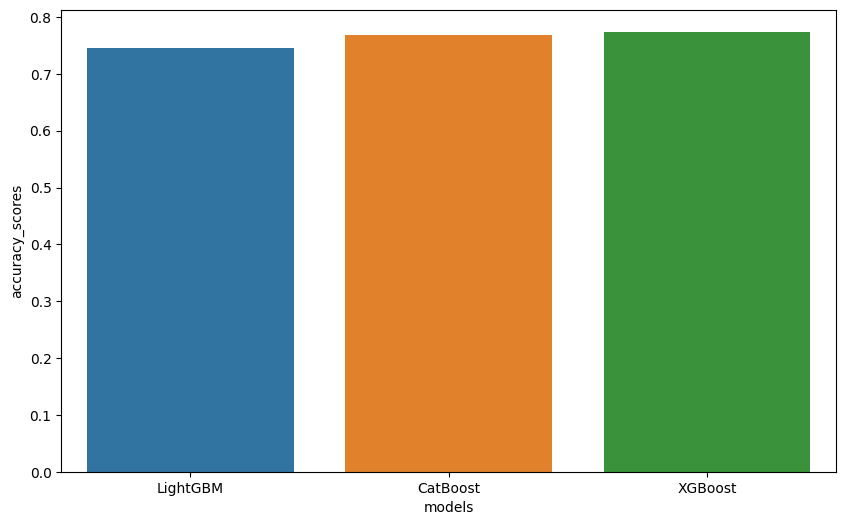

In [47]:
visual_performance(scores_with_different_models, 'accuracy_scores')   

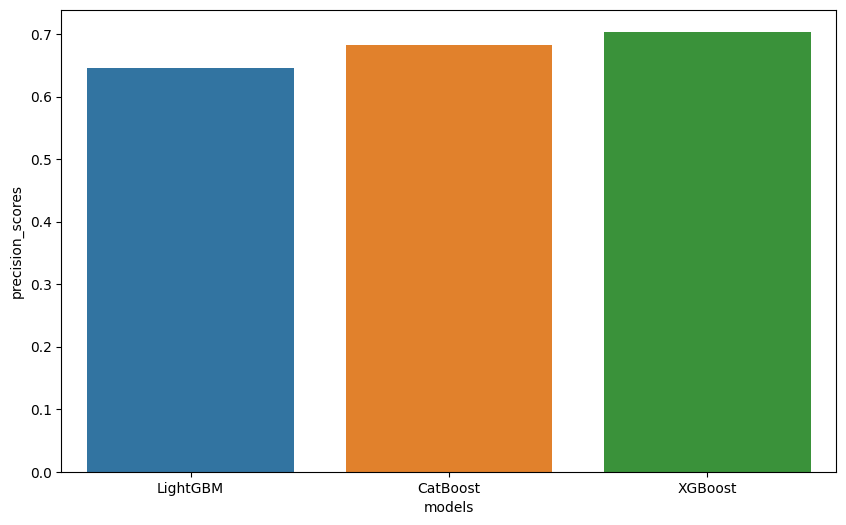

In [48]:

visual_performance(scores_with_different_models, 'precision_scores')

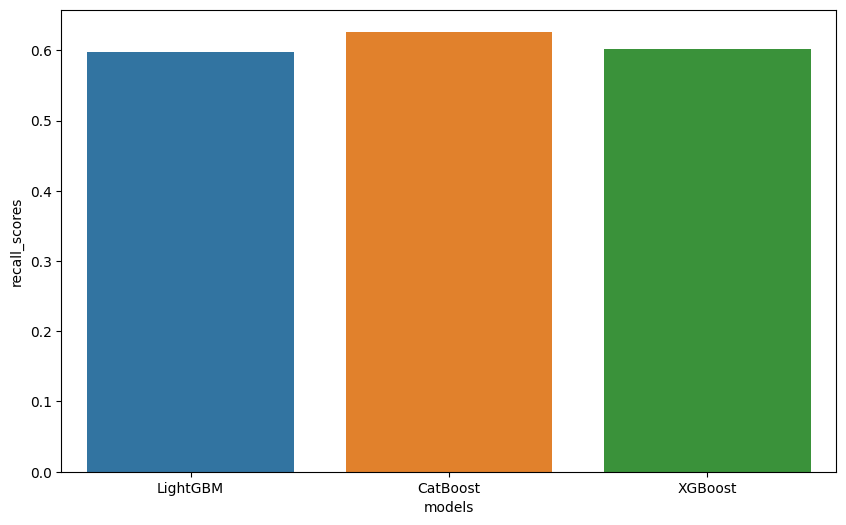

In [49]:
visual_performance(scores_with_different_models, 'recall_scores')

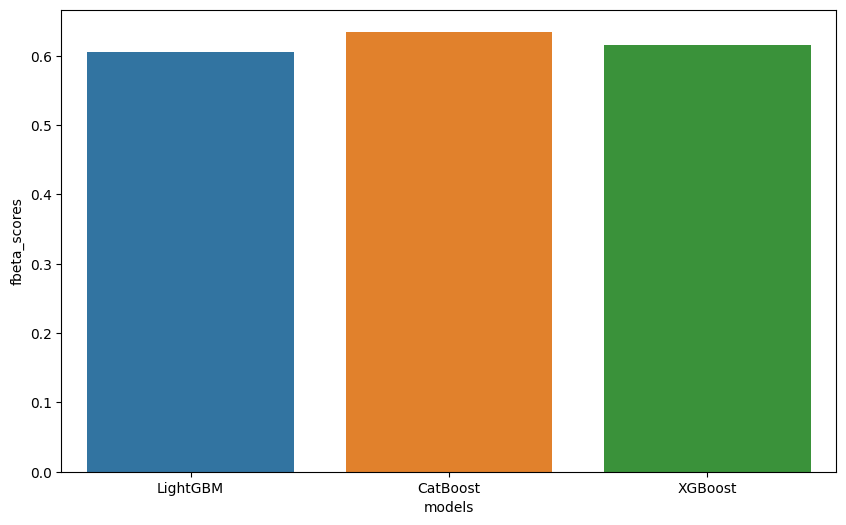

In [50]:

visual_performance(scores_with_different_models, 'fbeta_scores')

After all, CatBoost is the winner because i want to focus on recall and fbeta score, we can dig deeper into CatBoost to improve performance

In [51]:
ros = RandomOverSampler(random_state=42)
ros.fit(data_train, y_train)
X_resampled, y_resampled = ros.fit_resample(data_train, y_train)

In [52]:

y_resampled.value_counts()

0    450
1    450
Name: Outcome, dtype: int64

In [53]:
catboost_retrain = cb.CatBoostClassifier(**hyperparameters_storage["CatBoost"])
mean_accuracy_retrain, mean_precision_retrain, mean_recall_retrain, mean_fscore_retrain = kfold_training(catboost_retrain, X_resampled, y_resampled)
display_metrics(mean_accuracy_retrain, mean_precision_retrain, mean_recall_retrain, mean_fscore_retrain)

0:	learn: 0.6782862	total: 1.79ms	remaining: 715ms
1:	learn: 0.6707569	total: 3.37ms	remaining: 670ms
2:	learn: 0.6663560	total: 4.92ms	remaining: 651ms
3:	learn: 0.6527534	total: 6.43ms	remaining: 637ms
4:	learn: 0.6475425	total: 7.96ms	remaining: 629ms
5:	learn: 0.6366392	total: 9.43ms	remaining: 620ms
6:	learn: 0.6197305	total: 10.9ms	remaining: 610ms
7:	learn: 0.6106095	total: 12.4ms	remaining: 606ms
8:	learn: 0.6021835	total: 13.8ms	remaining: 601ms
9:	learn: 0.5931649	total: 15.3ms	remaining: 598ms
10:	learn: 0.5903209	total: 16.8ms	remaining: 593ms
11:	learn: 0.5860308	total: 18.4ms	remaining: 594ms
12:	learn: 0.5796158	total: 20.1ms	remaining: 599ms
13:	learn: 0.5763894	total: 21.6ms	remaining: 594ms
14:	learn: 0.5700227	total: 23ms	remaining: 590ms
15:	learn: 0.5651639	total: 24.3ms	remaining: 582ms
16:	learn: 0.5575858	total: 25.4ms	remaining: 573ms
17:	learn: 0.5523604	total: 26.8ms	remaining: 568ms
18:	learn: 0.5489511	total: 28.5ms	remaining: 571ms
19:	learn: 0.5429123	tot

In [54]:
joblib.dump(catboost, r"E:\BaoLong\mlops_diabetes_prediction\models/model_0.8518518518518519.pkl")

['E:\\BaoLong\\mlops_diabetes_prediction\\models/model_0.8518518518518519.pkl']

In [55]:

clf = joblib.load(r"E:\BaoLong\mlops_diabetes_prediction\models/model_0.8518518518518519.pkl")
y_predict = clf.predict(data_test)
accuracy, precision, recall, f_score = metrics(y_test, y_predict)
display_metrics(accuracy, precision, recall, f_score)

Accuracy: 0.72727
Precision: 0.60000
Recall: 0.66667
Fbeta_score: 0.65455
